## Lead Scoring Case Study

#### Problem Statement

X Education, an online course provider for industry professionals, struggles with a low lead conversion rate of 30%. Despite acquiring many leads through website visits, marketing campaigns, and referrals, only a fraction convert into paying customers. To improve efficiency, the company seeks a predictive model to identify high-potential "Hot Leads." The goal is to assign a lead score to each prospect, prioritizing those with a higher likelihood of conversion. By focusing efforts on these leads, X Education aims to increase its lead conversion rate to approximately 80%.

A data set has been provided and here are the following steps (broadly classified) that will be performed for model building

1. Data Understanding and Cleaning
2. Exploratory Data Analysis
3. Data Preparation
4. Train Test Split
5. Model Building
6. Model Evaluation

## Step 1: Data Understanding and Cleaning

In [4]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:

# Importing Pandas and NumPy
import pandas as pd, numpy as np

#pd.set_option('display.max_columns', None)  # Show all columns
#pd.set_option('display.max_rows', None)     # Show all rows (optional)


#importing sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, precision_recall_curve

# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns

# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [10]:
# Reading the data set

leads = pd.read_csv("leads.csv")

#### Let us inspect the dataset

In [12]:
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [14]:
leads.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


In [16]:
leads.shape # Let's check the dimensions of the dataframe

(9240, 37)

In [18]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

### Data Preparation

##### Converting the binary variables Yes / No to 0/1

In [20]:
def is_yes_no_column(col):
    unique_values = leads[col].dropna().unique()  # Get unique values excluding NaN
    return set(unique_values) <= {"Yes", "No"}  # Check if values are only "Yes" and "No"

# Get list of Yes/No columns
yes_no_columns = [col for col in leads.columns if is_yes_no_column(col)]

# Print the column names
print("Columns with only 'Yes' and 'No':")
print(yes_no_columns)

Columns with only 'Yes' and 'No':
['Do Not Email', 'Do Not Call', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview']


In [22]:
##Now we have got the list of variables to map

varlist =  ['Do Not Email', 'Do Not Call', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums',
            'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 
           'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque', 
            'A free copy of Mastering The Interview']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function to the housing list
leads[varlist] = leads[varlist].apply(binary_map)

In [24]:
leads.head() #checking the dataset

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,0,0,0,0.0,0,0.0,...,0,Select,Select,02.Medium,02.Medium,15.0,15.0,0,0,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,0,0,0,5.0,674,2.5,...,0,Select,Select,02.Medium,02.Medium,15.0,15.0,0,0,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,...,0,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,0,1,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,...,0,Select,Mumbai,02.Medium,01.High,13.0,17.0,0,0,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,...,0,Select,Mumbai,02.Medium,01.High,15.0,18.0,0,0,Modified


### Checking for Missing Variables

In [27]:
(leads.isnull().sum()/len(leads))*100 ##Check percentage of Null values

Prospect ID                                       0.000000
Lead Number                                       0.000000
Lead Origin                                       0.000000
Lead Source                                       0.389610
Do Not Email                                      0.000000
Do Not Call                                       0.000000
Converted                                         0.000000
TotalVisits                                       1.482684
Total Time Spent on Website                       0.000000
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Country                                          26.634199
Specialization                                   15.562771
How did you hear about X Education               23.885281
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
Search                                            0.0000

In [29]:
# Replace Unknown in NaNs in the country col

leads['Country'] = leads['Country'].fillna('unknown')

In [31]:
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,0,0,0,0.0,0,0.0,...,0,Select,Select,02.Medium,02.Medium,15.0,15.0,0,0,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,0,0,0,5.0,674,2.5,...,0,Select,Select,02.Medium,02.Medium,15.0,15.0,0,0,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,0,0,1,2.0,1532,2.0,...,0,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,0,1,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,0,0,0,1.0,305,1.0,...,0,Select,Mumbai,02.Medium,01.High,13.0,17.0,0,0,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,0,0,1,2.0,1428,1.0,...,0,Select,Mumbai,02.Medium,01.High,15.0,18.0,0,0,Modified


In [33]:
##Replace the select with NaN

leads= leads.replace('Select', np.nan)

In [35]:
# checking for null columns

leads.isnull().sum()

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                             0
Specialization                                   3380
How did you hear about X Education               7250
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article           

In [37]:
# Checking the percentage of missing values

round(100*(leads.isnull().sum()/len(leads.index)), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                           0.00
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

Drop Missing Values above 40%

In [39]:
leads= leads.drop(columns=['Asymmetrique Activity Index','Asymmetrique Profile Index','Asymmetrique Activity Score','Asymmetrique Profile Score','How did you hear about X Education','Lead Quality','Lead Profile'],axis=1)

In [41]:
##Check for Null values

leads.isnull().sum()

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       137
Total Time Spent on Website                         0
Page Views Per Visit                              137
Last Activity                                     103
Country                                             0
Specialization                                   3380
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Search                                              0
Magazine                                            0
Newspaper Article                                   0
X Education Forums          

In [43]:
##Check for unique value.
leads.nunique()

Prospect ID                                      9240
Lead Number                                      9240
Lead Origin                                         5
Lead Source                                        21
Do Not Email                                        2
Do Not Call                                         2
Converted                                           2
TotalVisits                                        41
Total Time Spent on Website                      1731
Page Views Per Visit                              114
Last Activity                                      17
Country                                            38
Specialization                                     18
What is your current occupation                     6
What matters most to you in choosing a course       3
Search                                              2
Magazine                                            1
Newspaper Article                                   2
X Education Forums          

In [45]:
# ignoring the data rows where there is null in 'What matters most to you in choosing a course' column

leads = leads[~pd.isna(leads['What matters most to you in choosing a course'])]

In [47]:
leads.isnull().sum()

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       130
Total Time Spent on Website                         0
Page Views Per Visit                              130
Last Activity                                     103
Country                                             0
Specialization                                   1929
What is your current occupation                     0
What matters most to you in choosing a course       0
Search                                              0
Magazine                                            0
Newspaper Article                                   0
X Education Forums          

Columns with low variance and identical observations throughout the dataset do not contribute meaningfully to the analysis. Therefore, we can remove them. The columns that fall into this category include: 'I agree to pay the amount through cheque,' 'Get updates on DM Content,' 'Receive More Updates About Our Courses,' 'Update me on Supply Chain Content,' and 'Magazine.'

In [49]:
leads=leads.drop(columns=['I agree to pay the amount through cheque', 'Get updates on DM Content', 'Receive More Updates About Our Courses','Update me on Supply Chain Content', 'Magazine'],axis=1)

In [51]:
# checking for null columns

leads.isnull().sum()

Prospect ID                                         0
Lead Number                                         0
Lead Origin                                         0
Lead Source                                        36
Do Not Email                                        0
Do Not Call                                         0
Converted                                           0
TotalVisits                                       130
Total Time Spent on Website                         0
Page Views Per Visit                              130
Last Activity                                     103
Country                                             0
Specialization                                   1929
What is your current occupation                     0
What matters most to you in choosing a course       0
Search                                              0
Newspaper Article                                   0
X Education Forums                                  0
Newspaper                   

There are still null values here but we cannot drop them as they are important for analysis.Hence it is wise to do the imputation of the values

In [53]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.55
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.99
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.99
Last Activity                                     1.58
Country                                           0.00
Specialization                                   29.54
What is your current occupation                   0.00
What matters most to you in choosing a course     0.00
Search                                            0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

The Specilization column has 30% of the missing values let us impute them

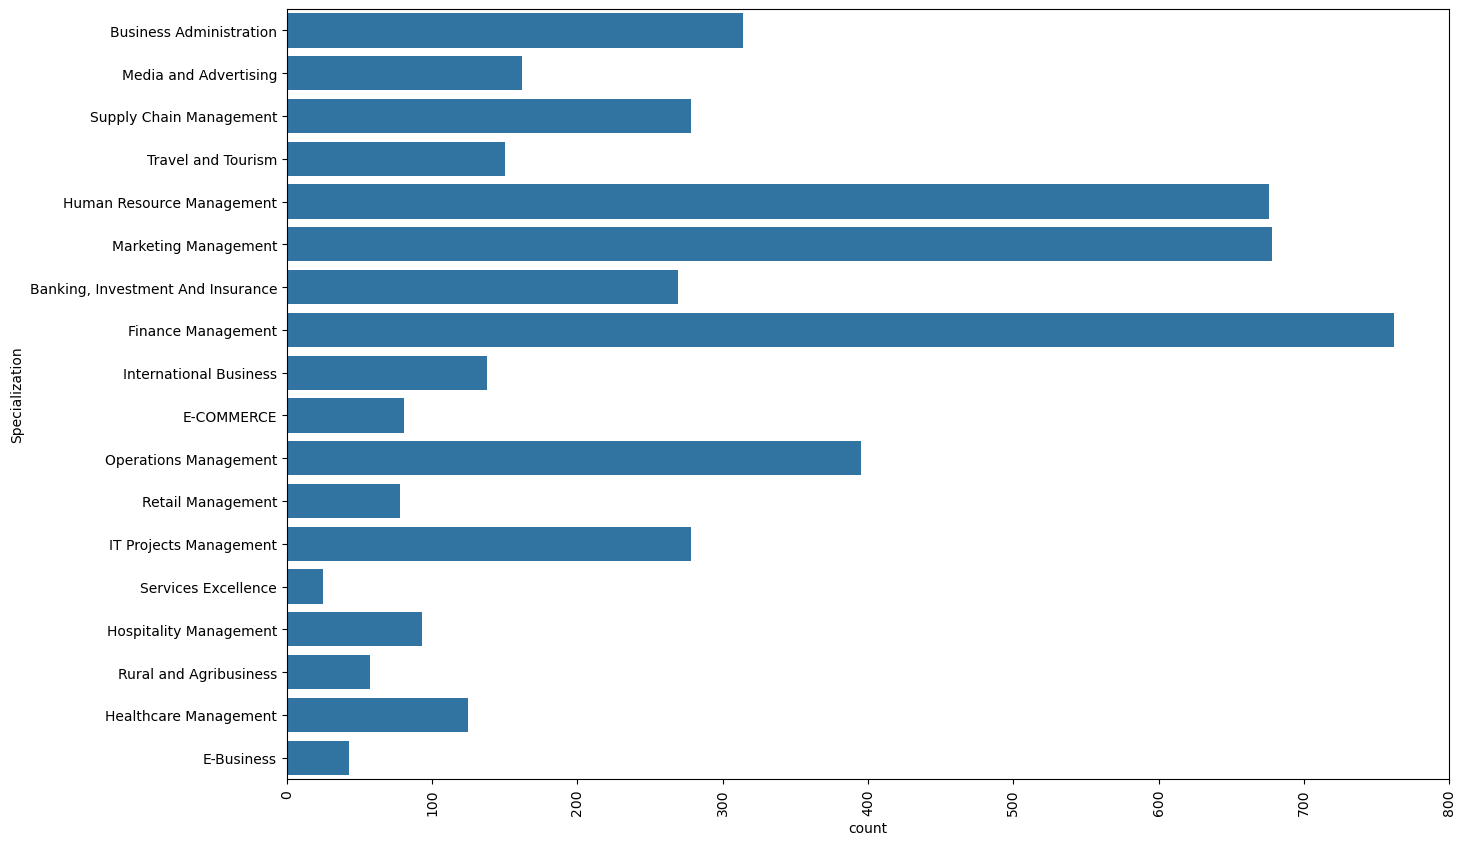

In [55]:
plt.figure(figsize=(15,10))
sns.countplot(leads['Specialization'])
plt.xticks(rotation=90)
plt.show()

In [57]:
##Creating a category for the missing values

##Create a category for missing values.
leads['Specialization'] = leads['Specialization'].replace(np.nan, 'Others')

In [59]:
round(leads['Specialization'].value_counts(normalize=True),2)

Specialization
Others                               0.30
Finance Management                   0.12
Marketing Management                 0.10
Human Resource Management            0.10
Operations Management                0.06
Business Administration              0.05
Supply Chain Management              0.04
IT Projects Management               0.04
Banking, Investment And Insurance    0.04
Media and Advertising                0.02
Travel and Tourism                   0.02
International Business               0.02
Healthcare Management                0.02
Hospitality Management               0.01
E-COMMERCE                           0.01
Retail Management                    0.01
Rural and Agribusiness               0.01
E-Business                           0.01
Services Excellence                  0.00
Name: proportion, dtype: float64

In [61]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.55
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.99
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.99
Last Activity                                     1.58
Country                                           0.00
Specialization                                    0.00
What is your current occupation                   0.00
What matters most to you in choosing a course     0.00
Search                                            0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

The city column has 34% of missing values let us drop them

In [63]:
leads= leads.drop('City',axis=1)

In [65]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.55
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.99
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.99
Last Activity                                     1.58
Country                                           0.00
Specialization                                    0.00
What is your current occupation                   0.00
What matters most to you in choosing a course     0.00
Search                                            0.00
Newspaper Article                                 0.00
X Education Forums                                0.00
Newspaper 

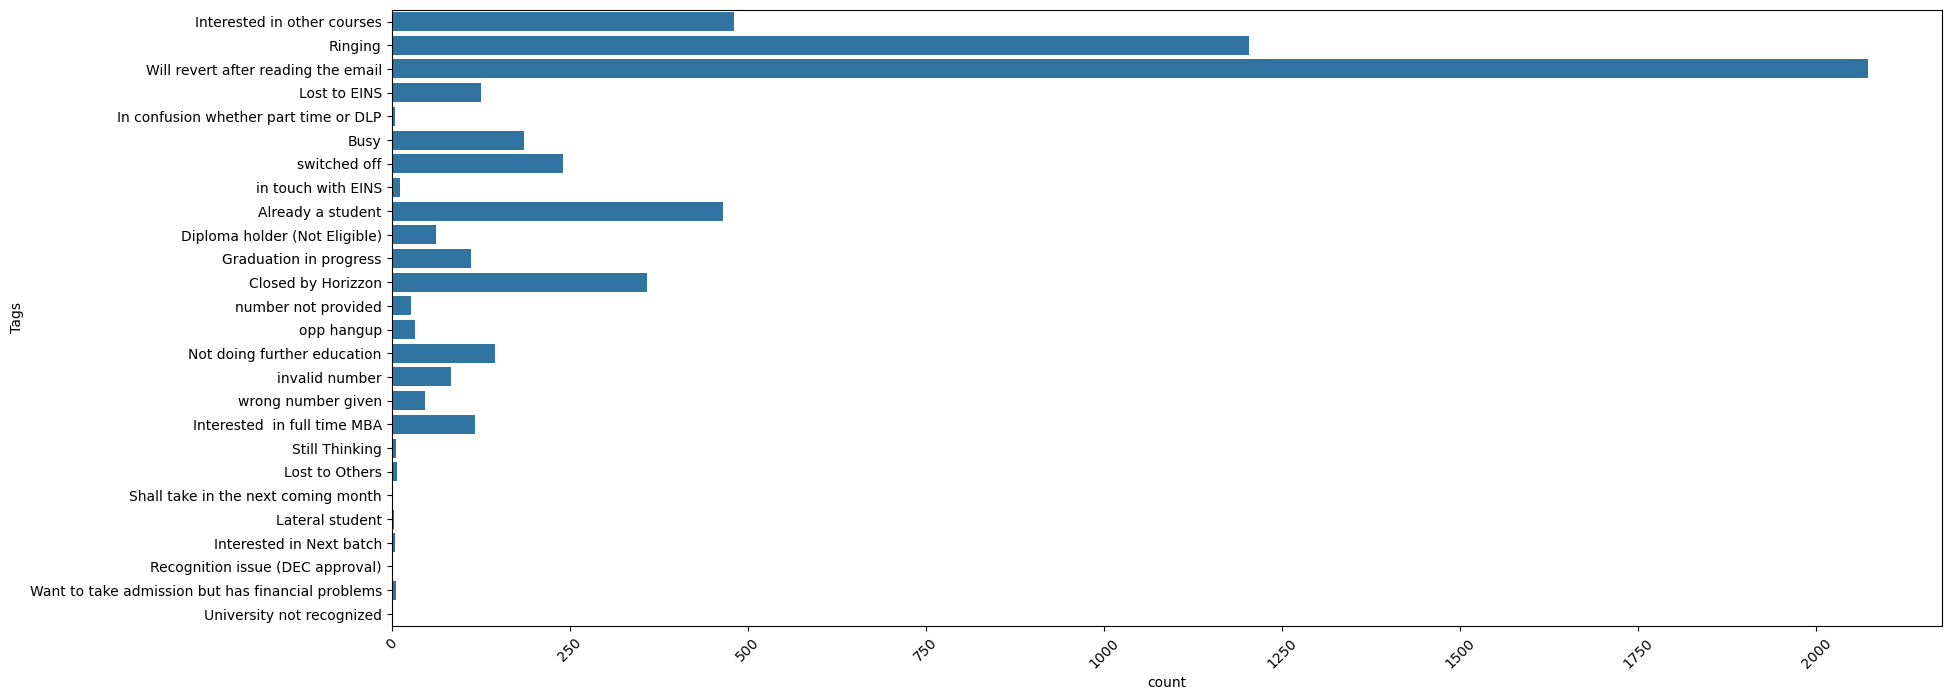

In [67]:
##Imputing the Tags column

plt.figure(figsize=(20,8))
sns.countplot(leads['Tags'])
plt.xticks(rotation=45)
plt.show()

In [69]:
round(leads['Tags'].value_counts(normalize=True),2)

Tags
Will revert after reading the email                  0.36
Ringing                                              0.21
Interested in other courses                          0.08
Already a student                                    0.08
Closed by Horizzon                                   0.06
switched off                                         0.04
Busy                                                 0.03
Not doing further education                          0.02
Lost to EINS                                         0.02
Interested  in full time MBA                         0.02
Graduation in progress                               0.02
invalid number                                       0.01
Diploma holder (Not Eligible)                        0.01
wrong number given                                   0.01
opp hangup                                           0.01
number not provided                                  0.00
in touch with EINS                                   0.00
Lost to O

In [71]:
## imputing missing data
leads['Tags']=leads['Tags'].replace(np.nan,'Will revert after reading the email')

In [73]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Prospect ID                                      0.00
Lead Number                                      0.00
Lead Origin                                      0.00
Lead Source                                      0.55
Do Not Email                                     0.00
Do Not Call                                      0.00
Converted                                        0.00
TotalVisits                                      1.99
Total Time Spent on Website                      0.00
Page Views Per Visit                             1.99
Last Activity                                    1.58
Country                                          0.00
Specialization                                   0.00
What is your current occupation                  0.00
What matters most to you in choosing a course    0.00
Search                                           0.00
Newspaper Article                                0.00
X Education Forums                               0.00
Newspaper                   

In [75]:
round(leads['TotalVisits'].value_counts(normalize=True),2)

TotalVisits
0.0      0.21
2.0      0.19
3.0      0.15
4.0      0.13
5.0      0.09
6.0      0.05
1.0      0.04
7.0      0.04
8.0      0.03
9.0      0.02
10.0     0.01
11.0     0.01
13.0     0.01
12.0     0.00
14.0     0.00
16.0     0.00
15.0     0.00
17.0     0.00
18.0     0.00
20.0     0.00
19.0     0.00
21.0     0.00
23.0     0.00
27.0     0.00
25.0     0.00
24.0     0.00
22.0     0.00
29.0     0.00
26.0     0.00
55.0     0.00
30.0     0.00
43.0     0.00
74.0     0.00
251.0    0.00
32.0     0.00
28.0     0.00
42.0     0.00
Name: proportion, dtype: float64

### 🔍 Conversion Rate by Lead Source
This chart shows the average conversion rate for each lead source. It highlights which channels bring in the most high-potential leads.


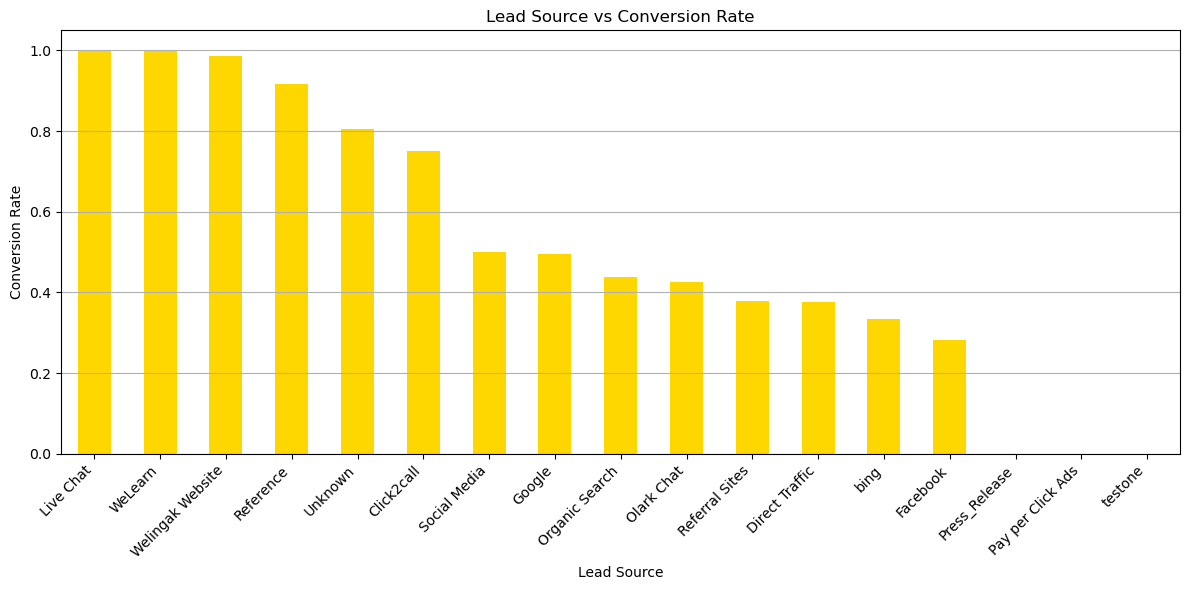

In [122]:
# Fill missing values for consistency
leads['Lead Source'] = leads['Lead Source'].fillna('Unknown')

# Group by Lead Source and compute mean conversion
lead_source_conv = leads.groupby('Lead Source')['Converted'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
lead_source_conv.plot(kind='bar', color='gold')
plt.title('Lead Source vs Conversion Rate')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [84]:
## imputing missing data
leads['TotalVisits']=leads['TotalVisits'].replace(np.nan,'0.0')

In [86]:
round(leads['Page Views Per Visit'].value_counts(normalize=True),2)

Page Views Per Visit
0.00     0.21
2.00     0.21
3.00     0.14
4.00     0.10
1.00     0.07
         ... 
3.43     0.00
2.56     0.00
4.75     0.00
16.00    0.00
2.08     0.00
Name: proportion, Length: 106, dtype: float64

In [88]:
## imputing missing data
leads['Page Views Per Visit']=leads['Page Views Per Visit'].replace(np.nan,'0.0')

In [90]:
round(leads['Last Activity'].value_counts(normalize=True),2)

Last Activity
Email Opened                    0.38
SMS Sent                        0.34
Olark Chat Conversation         0.07
Page Visited on Website         0.07
Converted to Lead               0.05
Email Bounced                   0.03
Email Link Clicked              0.03
Form Submitted on Website       0.01
Unreachable                     0.01
Unsubscribed                    0.01
Had a Phone Conversation        0.00
Approached upfront              0.00
View in browser link Clicked    0.00
Email Received                  0.00
Email Marked Spam               0.00
Visited Booth in Tradeshow      0.00
Name: proportion, dtype: float64

In [92]:
values = [0.38, 0.34, 0.07, 0.07, 0.05, 0.03, 0.03, 0.01, 0.01, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]
mean_value = np.mean(values)

print("Mean:", mean_value)

Mean: 0.0625


In [94]:
## imputing missing data
leads['Last Activity']=leads['Last Activity'].replace(np.nan,'0.062')

Checking the missing values

### 📬 Conversion Rate by Last Activity
This chart shows how recent actions taken by the lead (like Email Opened or Chat) influence the likelihood of conversion.


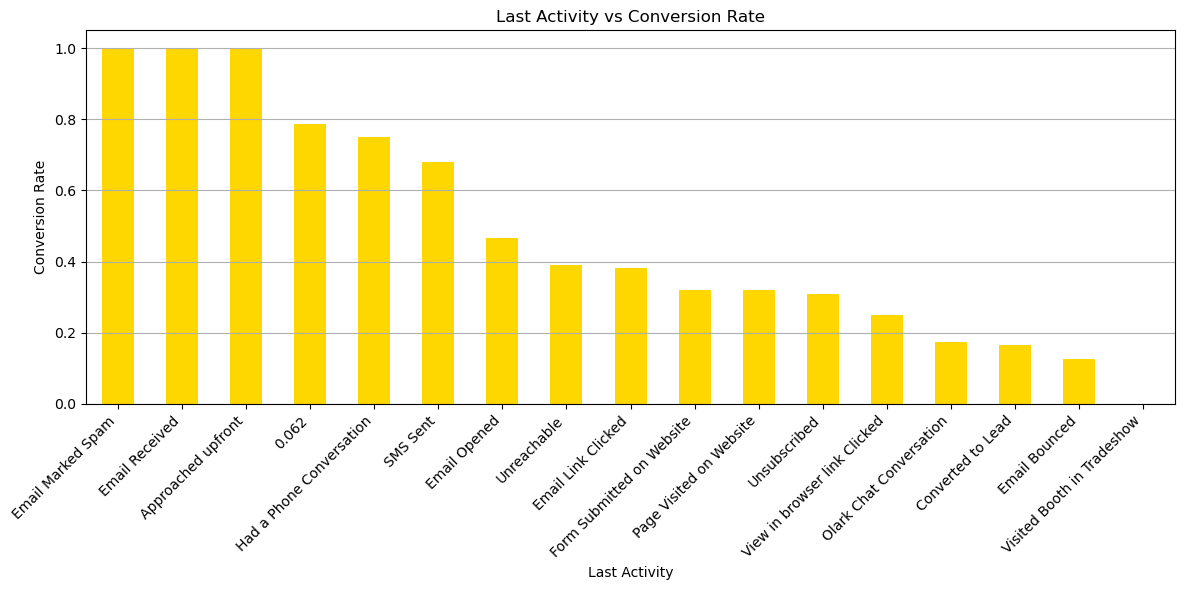

In [125]:
# Group and plot
last_activity_conv = leads.groupby('Last Activity')['Converted'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
last_activity_conv.plot(kind='bar', color='gold')
plt.title('Last Activity vs Conversion Rate')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### 🎯 Conversion Rate by Specialization
This chart shows which specializations are more likely to convert. It can help target audiences more effectively.


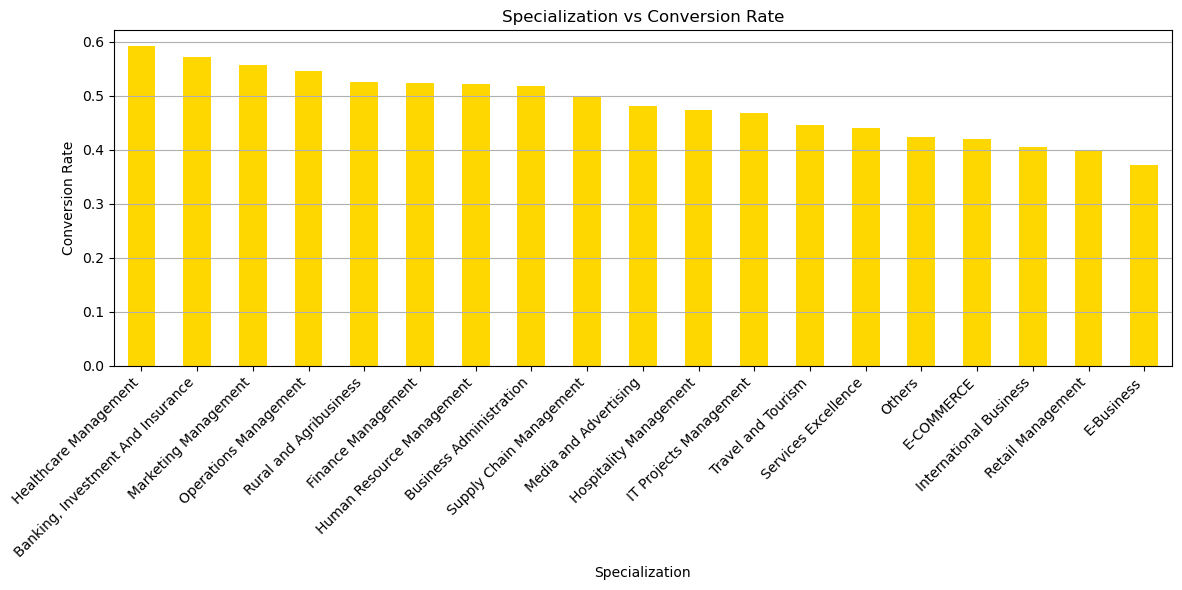

In [120]:
# Fill missing values
leads['Specialization'] = leads['Specialization'].fillna('Unknown')

# Group and plot
specialization_conv = leads.groupby('Specialization')['Converted'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
specialization_conv.plot(kind='bar', color='Gold')
plt.title('Specialization vs Conversion Rate')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [96]:
round(100*(leads.isnull().sum()/len(leads.index)), 2)

Prospect ID                                      0.0
Lead Number                                      0.0
Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Newspaper Article                                0.0
X Education Forums                               0.0
Newspaper                                     

In [98]:
# Removing Id values since they are not of any use in analysis
leads = leads.drop('Prospect ID',axis=1)
leads.shape

(6531, 23)

## Exploratory Data Analysis

Now the data cleaning part is done we will start with the EDA process to better understand the data

##

In [102]:
##Check the duplicates

leads[leads.duplicated()]

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,...,What matters most to you in choosing a course,Search,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Tags,A free copy of Mastering The Interview,Last Notable Activity


The data does not have any duplicates so we can start with the EDA

In [104]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6531 entries, 0 to 9239
Data columns (total 23 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   Lead Number                                    6531 non-null   int64 
 1   Lead Origin                                    6531 non-null   object
 2   Lead Source                                    6531 non-null   object
 3   Do Not Email                                   6531 non-null   int64 
 4   Do Not Call                                    6531 non-null   int64 
 5   Converted                                      6531 non-null   int64 
 6   TotalVisits                                    6531 non-null   object
 7   Total Time Spent on Website                    6531 non-null   int64 
 8   Page Views Per Visit                           6531 non-null   object
 9   Last Activity                                  6531 non-null   objec

Check for the leads converted

In [448]:
Converted = (sum(leads['Converted'])/len(leads['Converted'].index))*100
Converted

48.85928647986526

Almost 49% leads are converted

### Univariate Analysis

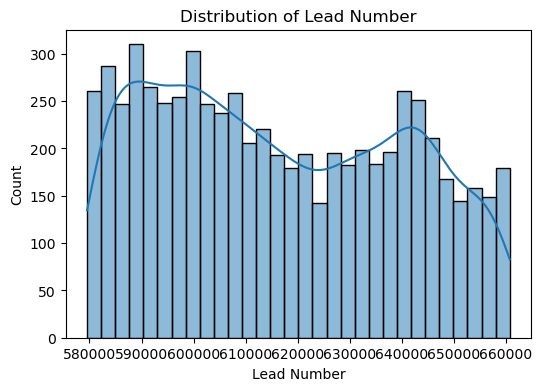

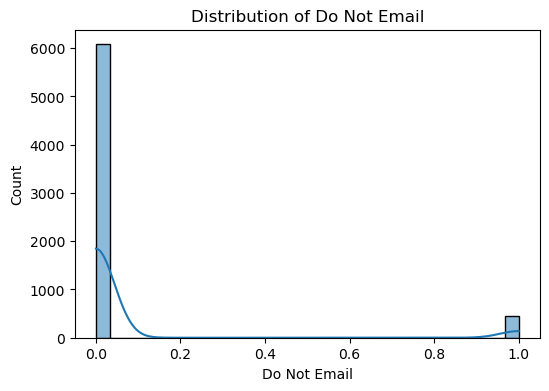

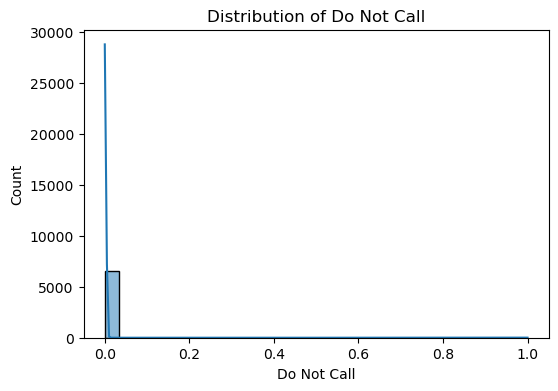

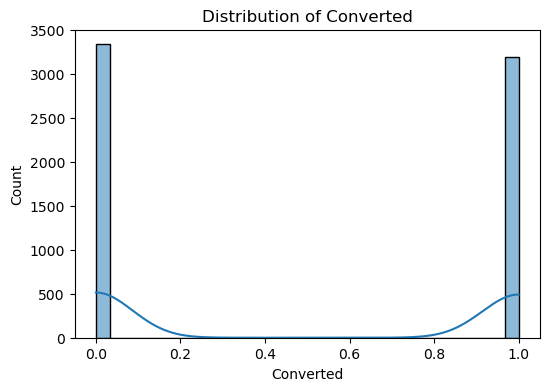

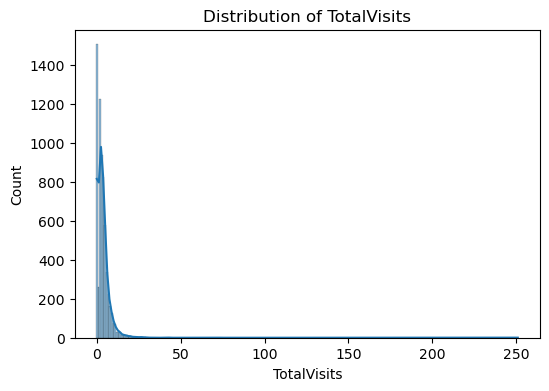

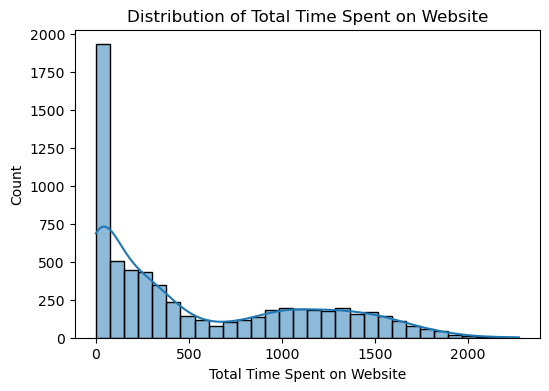

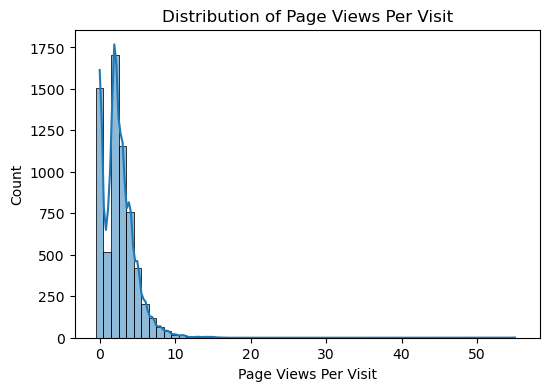

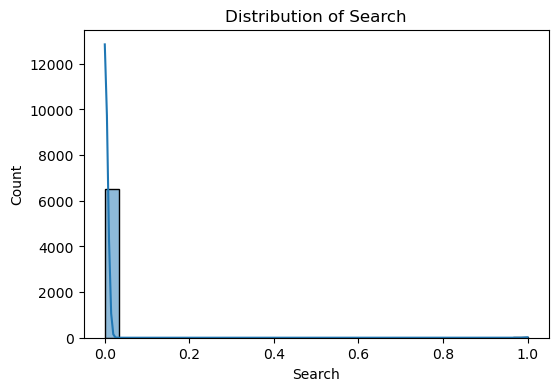

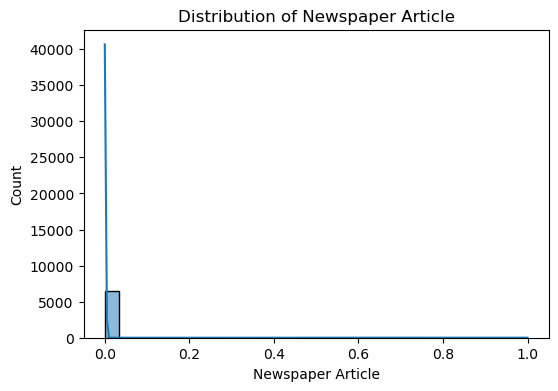

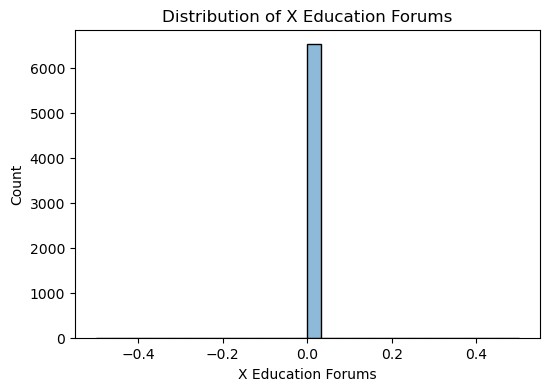

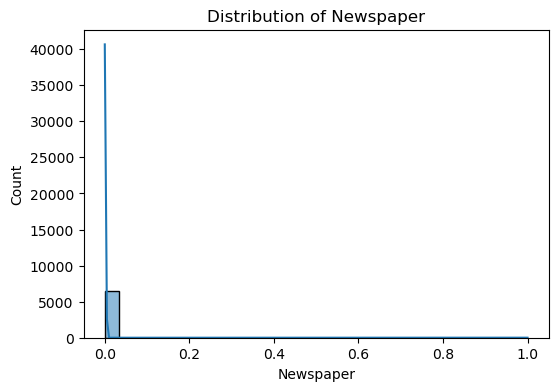

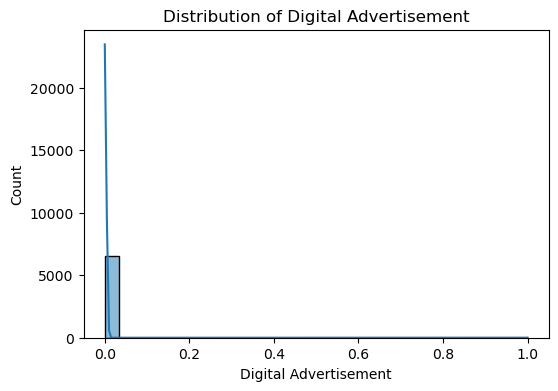

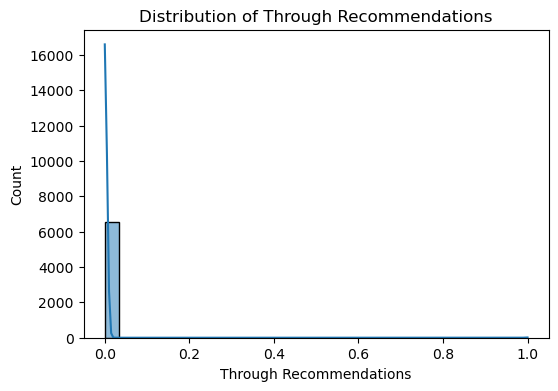

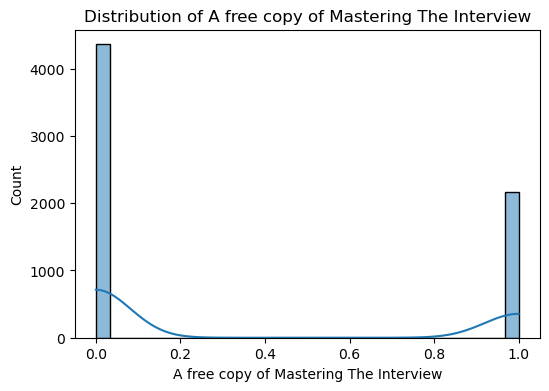

In [449]:
# Univariate Analysis - Distribution of numeric features
for col in numeric_cols:
    if col in leads.columns:
        plt.figure(figsize=(6, 4))
        sns.histplot(leads[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.show()


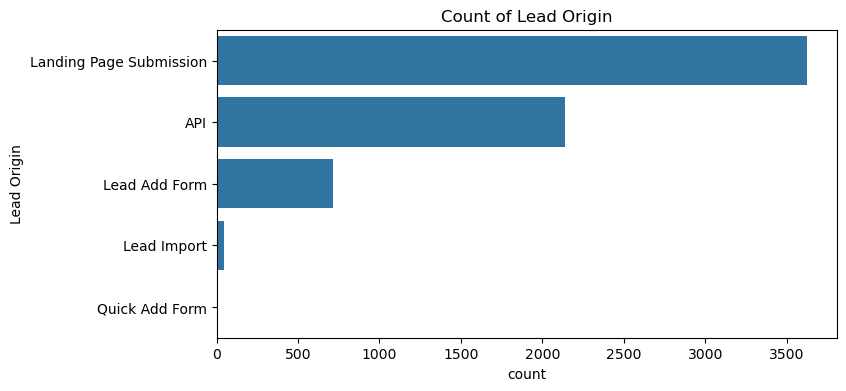

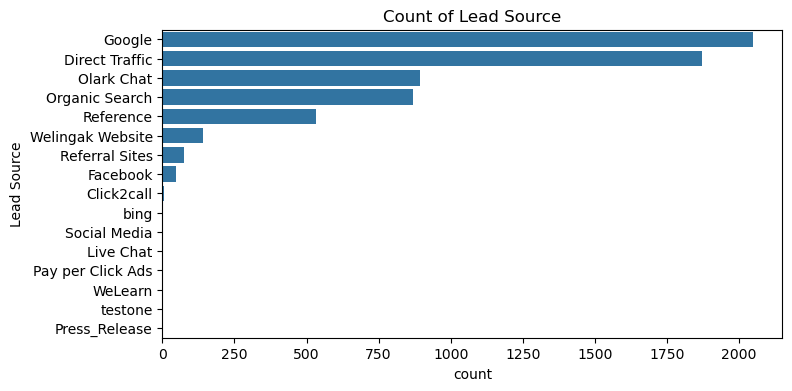

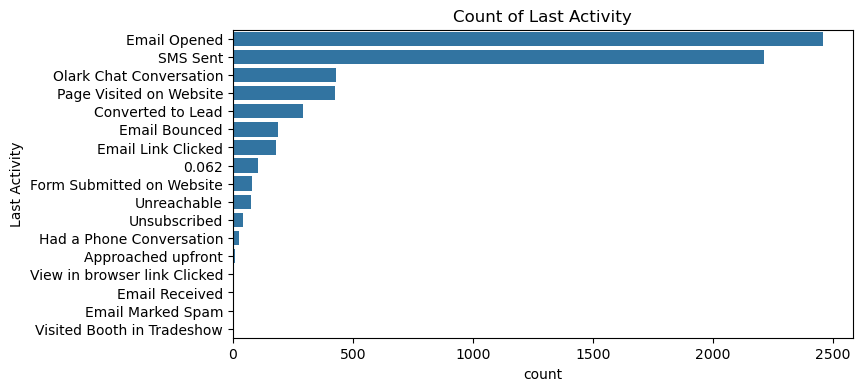

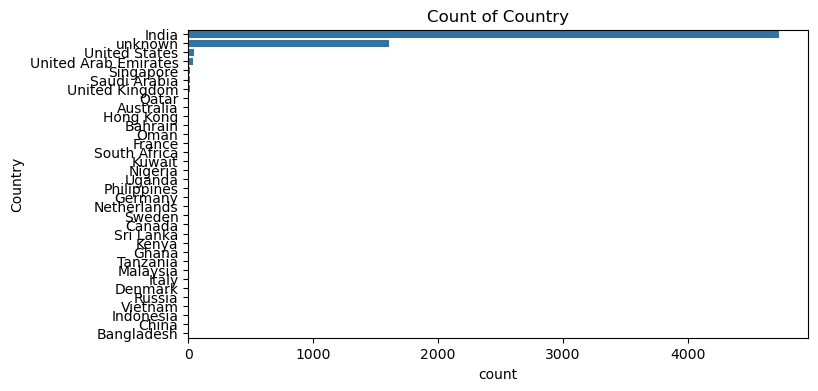

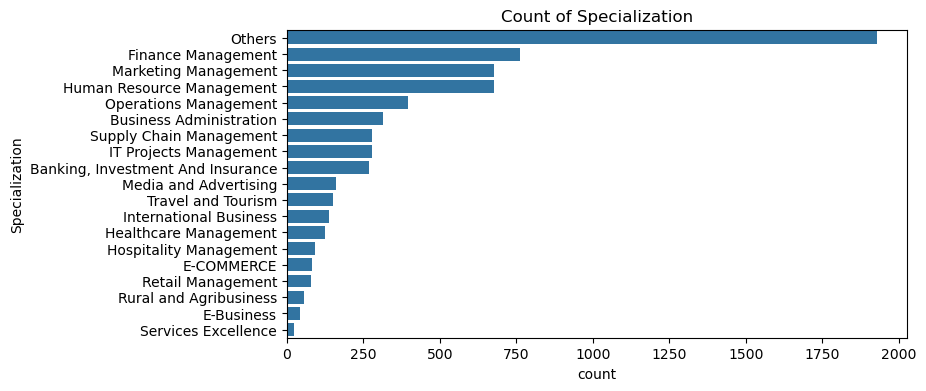

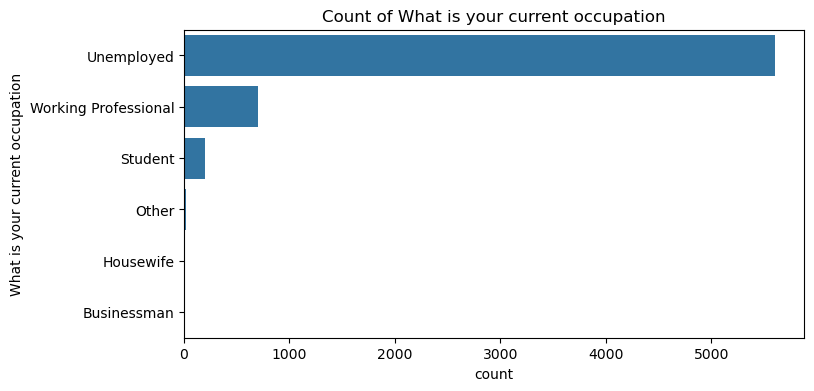

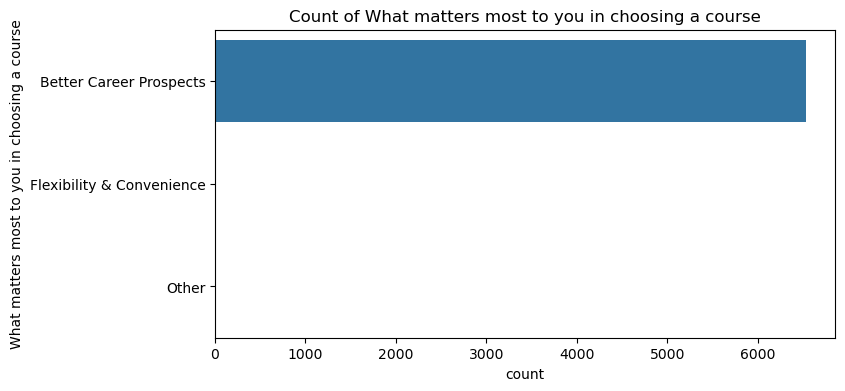

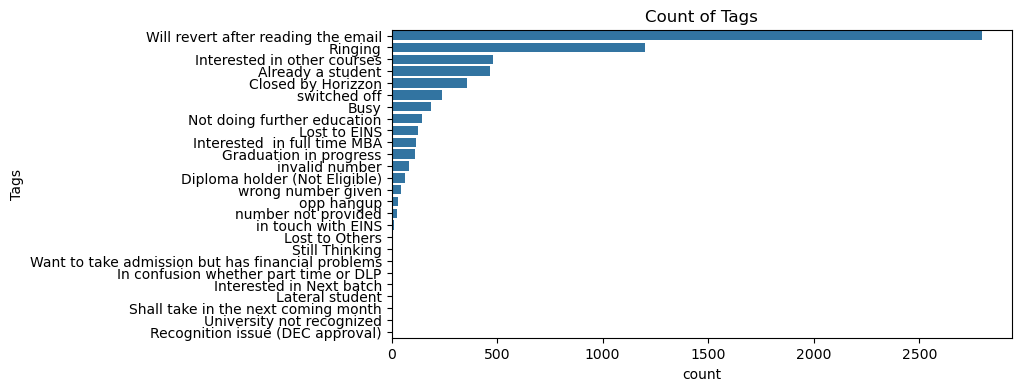

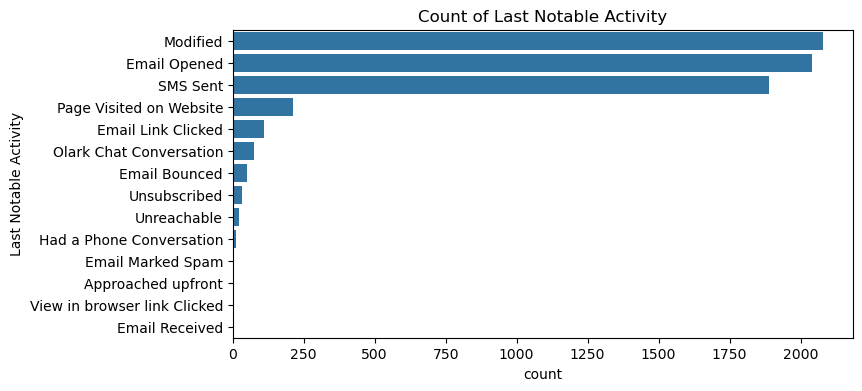

In [450]:
# Univariate Analysis - Categorical features
for col in categorical_cols:
    if col in leads.columns:
        plt.figure(figsize=(8, 4))
        sns.countplot(y=leads[col], order=leads[col].value_counts().index)
        plt.title(f'Count of {col}')
        plt.show()

### Bivariate Analysis

In [451]:
print(leads.dtypes)

Lead Number                                       int64
Lead Origin                                      object
Lead Source                                      object
Do Not Email                                      int64
Do Not Call                                       int64
Converted                                         int64
TotalVisits                                      object
Total Time Spent on Website                       int64
Page Views Per Visit                             object
Last Activity                                    object
Country                                          object
Specialization                                   object
What is your current occupation                  object
What matters most to you in choosing a course    object
Search                                            int64
Newspaper Article                                 int64
X Education Forums                                int64
Newspaper                                       

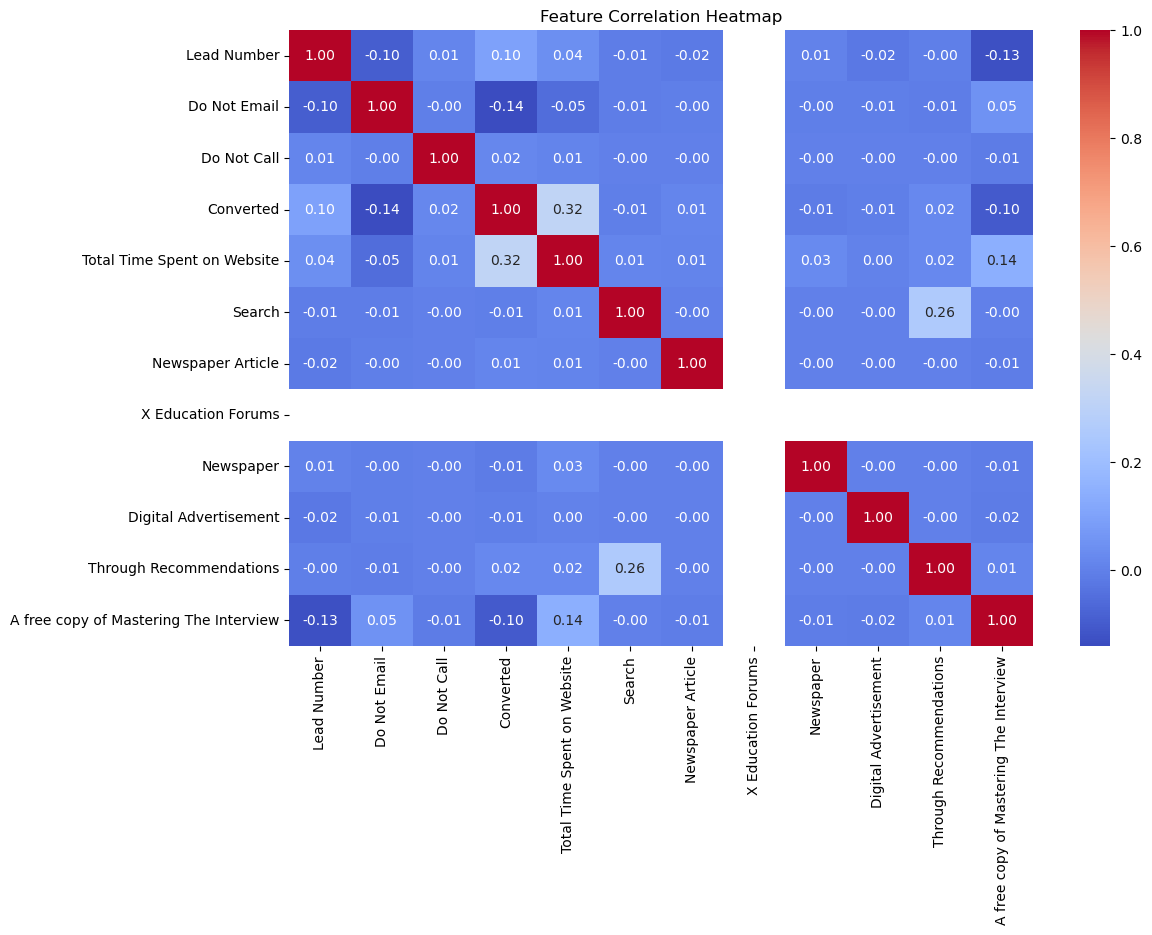

In [452]:
plt.figure(figsize=(12, 8))
sns.heatmap(leads.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

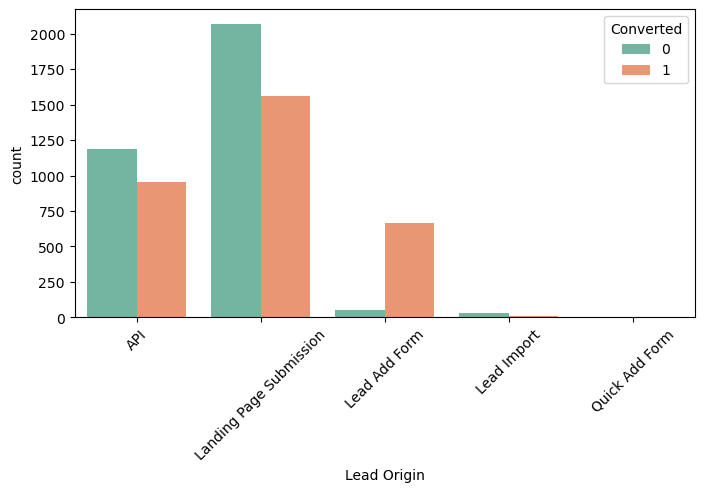

In [453]:
plt.figure(figsize=(8,4))
sns.countplot(x ="Lead Origin",hue="Converted", data = leads,palette='Set2')
plt.xticks(rotation = 45)
plt.show()

The API and Landing Page Submissions generate a significant number of leads, with conversion rates ranging from 31% to 35%.

The Lead Add Form has a high conversion rate but a relatively low lead count.

Enhancing websites and software can improve lead conversion rates for API and Landing Page Submissions. Additionally, leveraging the high conversion potential of the Lead Add Form should also be a priority.

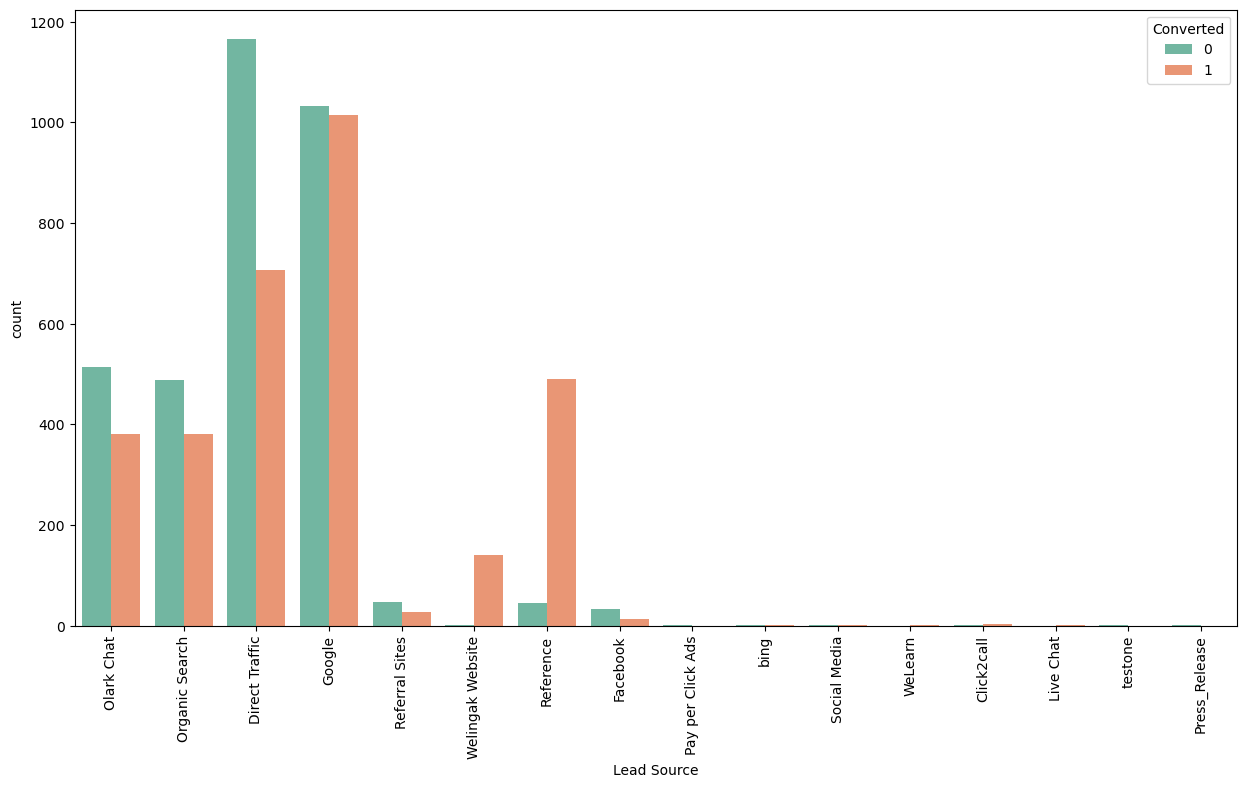

In [454]:
plt.figure(figsize=(15,8))
sns.countplot(x ="Lead Source",hue="Converted", data = leads,palette='Set2')
plt.xticks(rotation = 90)
plt.show()

There are too many lead sources with a very few data let us group them as Others

In [455]:
leads['Lead Source']= leads['Lead Source'].replace(['Pay per Click Ads', 'bing','Social Media','WeLearn','Click2call','Live Chat','welearnblog_Home','youtubechannel','testone','Press_Release','NC_EDM'], 'Other Sources')

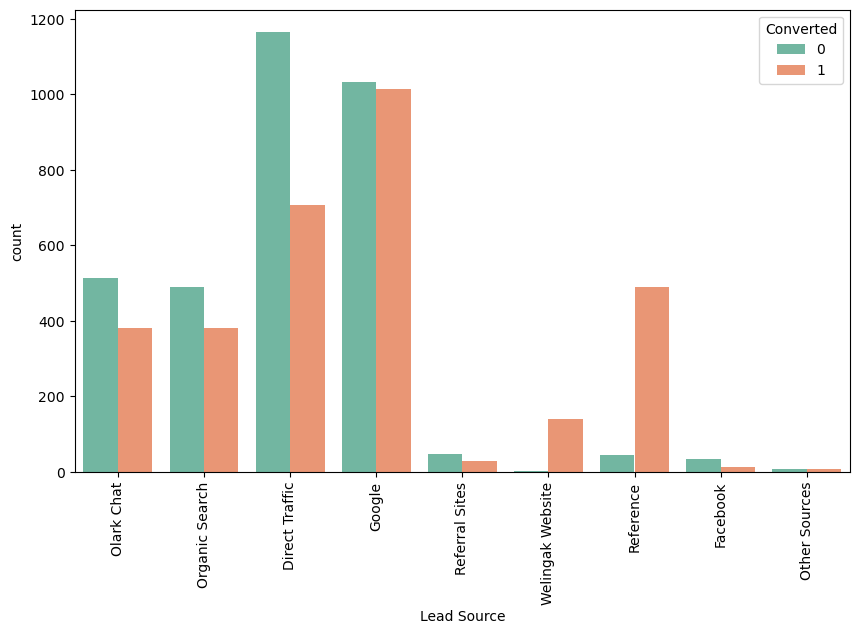

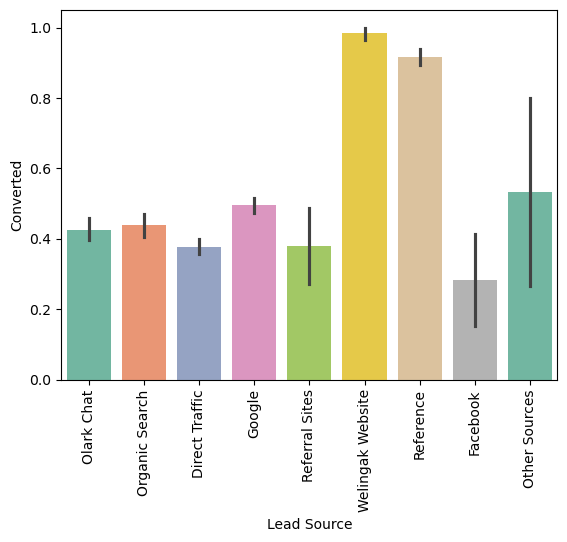

In [456]:
##Revisualize the column-
plt.figure(figsize=(10,6))
sns.countplot(x ="Lead Source",hue="Converted", data = leads,palette='Set2')
plt.xticks(rotation = 90)
plt.show()

sns.barplot(x ="Lead Source",y="Converted", data = leads,palette='Set2')
# plt.show()
plt.xticks(rotation = 90)
plt.show()

Google and Direct Traffic generate the highest number of leads, with a conversion rate of approximately 35%.

The Welingak Website and References have the highest conversion percentages, with the Welingak Website being the top source for converted leads.

Since Olark Chat and Organic Search also generate a high volume of leads, enhancing these channels alongside Google and Direct Traffic could be beneficial for the organization.

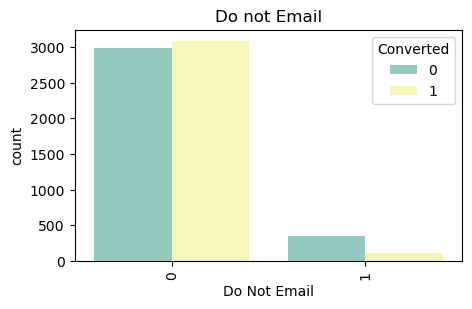

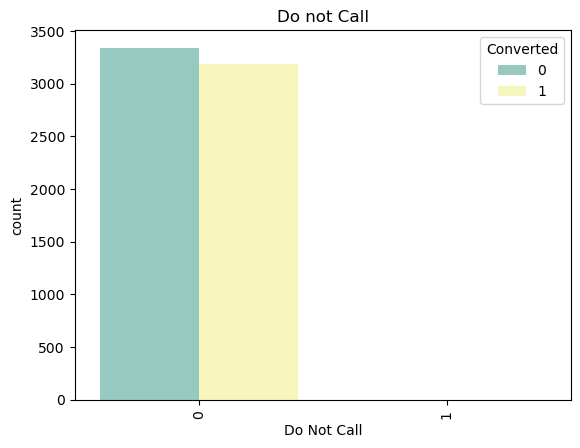

In [457]:
plt.figure(figsize=(5,3))
sns.countplot(x = "Do Not Email", hue = "Converted", data = leads,palette='Set3')
plt.xticks(rotation = 90)
plt.title('Do not Email')
plt.show()
sns.countplot(x = "Do Not Call", hue = "Converted", data = leads,palette='Set3')
plt.xticks(rotation = 90)
plt.title('Do not Call')
plt.show()

We will create boxplots to analyze the percentile range and identify any outliers.

If outliers are detected, we will cap them and re-visualize the data for better insights.

In [458]:
leads['TotalVisits'].describe()

count     6531.0
unique      38.0
top          0.0
freq      1375.0
Name: TotalVisits, dtype: float64

In [459]:
non_numeric_values = leads[~leads['TotalVisits'].astype(str).str.replace('.', '', 1).str.isnumeric()]
print(non_numeric_values)

Empty DataFrame
Columns: [Lead Number, Lead Origin, Lead Source, Do Not Email, Do Not Call, Converted, TotalVisits, Total Time Spent on Website, Page Views Per Visit, Last Activity, Country, Specialization, What is your current occupation, What matters most to you in choosing a course, Search, Newspaper Article, X Education Forums, Newspaper, Digital Advertisement, Through Recommendations, Tags, A free copy of Mastering The Interview, Last Notable Activity]
Index: []

[0 rows x 23 columns]


In [460]:
leads['TotalVisits'] = pd.to_numeric(leads['TotalVisits'], errors='coerce')

In [461]:
leads['TotalVisits'].fillna(leads['TotalVisits'].median(), inplace=True)  # Replace NaN with median

In [462]:
percentile_value = leads['TotalVisits'].quantile([0.05, 0.95]).values
print(percentile_value[0])
print(percentile_value[1])


0.0
10.0


In [463]:
leads['TotalVisits'].describe(percentiles=[0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99])

count    6531.000000
mean        3.519216
std         4.824807
min         0.000000
5%          0.000000
10%         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
90%         7.000000
95%        10.000000
99%        17.000000
max       251.000000
Name: TotalVisits, dtype: float64

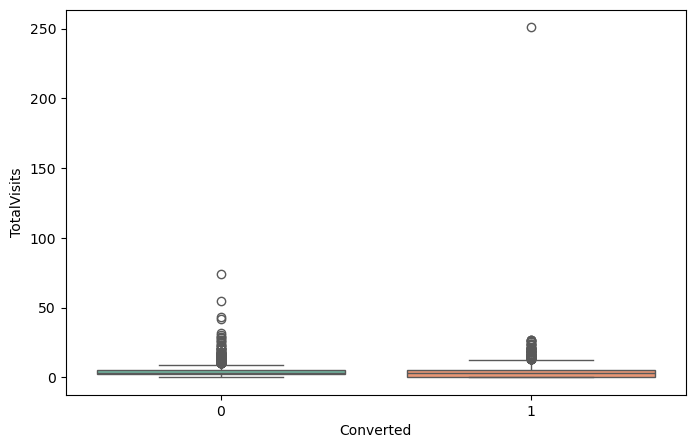

In [464]:
plt.figure(figsize=(8,5))
sns.boxplot(y='TotalVisits', x='Converted', data= leads, palette='Set2')
plt.show()

In [465]:
leads['Total Time Spent on Website'] = pd.to_numeric(leads['Total Time Spent on Website'], errors='coerce')

In [466]:
leads['Total Time Spent on Website'].describe(percentiles=[0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99])

count    6531.000000
mean      540.897872
std       568.212123
min         0.000000
5%          0.000000
10%         0.000000
25%        35.000000
50%       293.000000
75%      1031.500000
90%      1439.000000
95%      1600.500000
99%      1850.700000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64

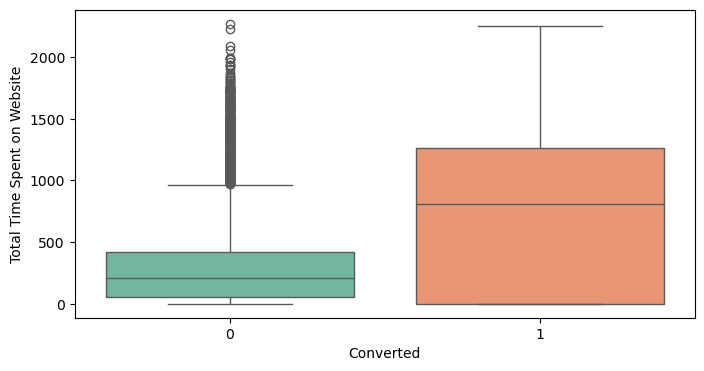

In [467]:
plt.figure(figsize=(8,4))
sns.boxplot(y='Total Time Spent on Website', x='Converted', data= leads, palette='Set2')
plt.show()

In [468]:
leads['Page Views Per Visit'] = pd.to_numeric(leads['Page Views Per Visit'], errors='coerce')

In [469]:
leads['Page Views Per Visit'].describe(percentiles=[0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99])

count    6531.000000
mean        2.419505
std         2.173470
min         0.000000
5%          0.000000
10%         0.000000
25%         1.000000
50%         2.000000
75%         3.500000
90%         5.000000
95%         6.000000
99%         9.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

In [470]:
percentile_range = leads['Page Views Per Visit'].quantile([0.05,0.95]).values
leads['Page Views Per Visit'][leads['Page Views Per Visit'] <= percentile_range[0]] = percentile_range[0]
leads['Page Views Per Visit'][leads['Page Views Per Visit'] >= percentile_range[1]] = percentile_range[1]

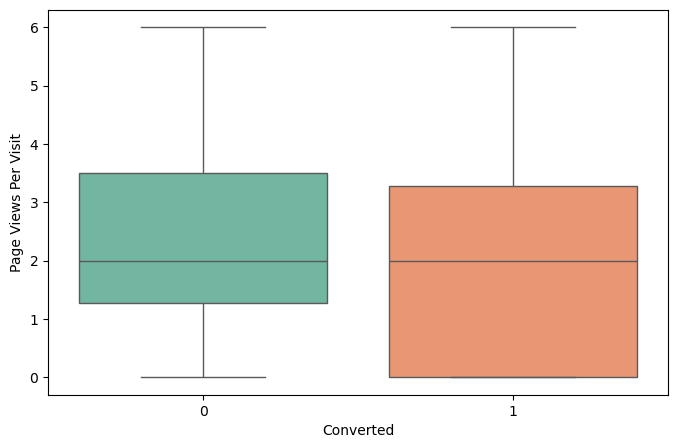

In [471]:
##Visualize the column-
plt.figure(figsize=(8,5))
sns.boxplot(y='Page Views Per Visit', x='Converted', data= leads, palette='Set2')
plt.show()

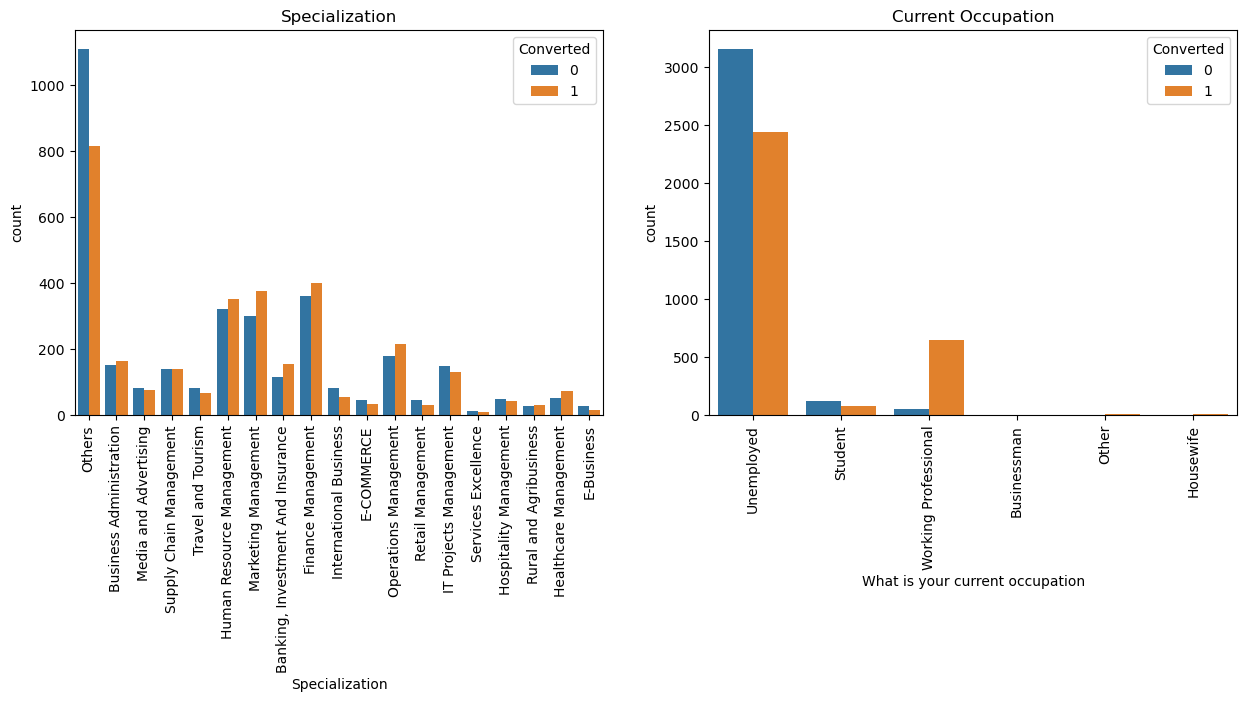

In [472]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.countplot(x='Specialization', hue='Converted', data= leads).tick_params(axis='x', rotation = 90)
plt.title('Specialization')

plt.subplot(1,2,2)
sns.countplot(x='What is your current occupation', hue='Converted', data= leads).tick_params(axis='x', rotation = 90)
plt.title('Current Occupation')
plt.show()


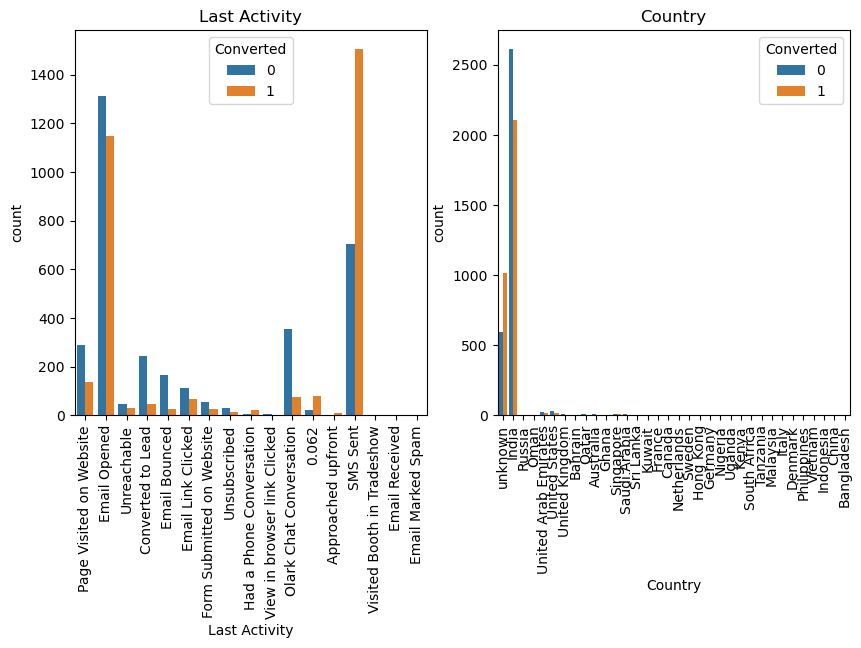

In [473]:
plt.figure(figsize = (10,5))

plt.subplot(1,2,1)
sns.countplot(x='Last Activity', hue='Converted', data= leads).tick_params(axis='x', rotation = 90)
plt.title('Last Activity')

plt.subplot(1,2,2)
sns.countplot(x='Country', hue='Converted', data= leads).tick_params(axis='x', rotation = 90)
plt.title('Country')
plt.show()

Leads whose last activity was SMS Sent are more likely to get converted and also those who opened their respective emails last were noted to be converted.
Since India is the only country where the count of potential leads is the most, therefore the highest conversion rate is also seen in India.Thus, Country is not a significant parameter for analysis.

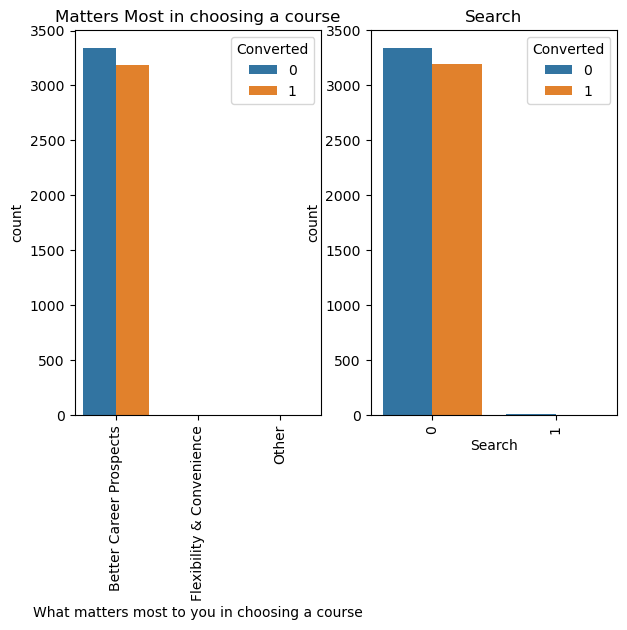

In [474]:
plt.figure(figsize = (7,5))

plt.subplot(1,2,1)
sns.countplot(x='What matters most to you in choosing a course', hue='Converted', data= leads).tick_params(axis='x', rotation = 90)
plt.title('Matters Most in choosing a course')
# plt.show()


plt.subplot(1,2,2)
sns.countplot(x='Search', hue='Converted', data= leads).tick_params(axis='x', rotation = 90)
plt.title('Search')
plt.show()

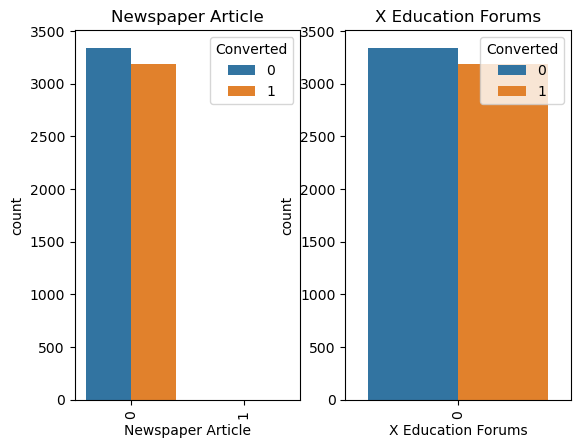

In [475]:
plt.subplot(1,2,1)
sns.countplot(x='Newspaper Article', hue='Converted', data= leads).tick_params(axis='x', rotation = 90)
plt.title('Newspaper Article')
# plt.show()


plt.subplot(1,2,2)
sns.countplot(x='X Education Forums', hue='Converted', data= leads).tick_params(axis='x', rotation = 90)
plt.title('X Education Forums')
plt.show()

## Data Preparation

After EDA we have drawn certain inferences and Now the next step is preparing data for Model Building

In [478]:
##Creating the Dummy Variables


dummy_var= pd.get_dummies(leads[['Lead Origin','Lead Source','Specialization','Last Notable Activity','Last Activity','What is your current occupation']],drop_first=True)
dummy_var.head(25)

,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Facebook,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Sources,Lead Source_Reference,...,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
0,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
4,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
6,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
10,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
11,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
12,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
13,True,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False


In [479]:
## Convert to int
dummy_var= dummy_var.astype(int)

In [480]:
### Adding to main dataset leads
main_cols_dummy=['Lead Origin','Lead Source','Specialization','Last Notable Activity','Last Activity','What is your current occupation']
leads=pd.concat([leads,dummy_var],axis=1)

In [482]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6531 entries, 0 to 9239
Data columns (total 87 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Lead Number                                           6531 non-null   int64  
 1   Lead Origin                                           6531 non-null   object 
 2   Lead Source                                           6495 non-null   object 
 3   Do Not Email                                          6531 non-null   int64  
 4   Do Not Call                                           6531 non-null   int64  
 5   Converted                                             6531 non-null   int64  
 6   TotalVisits                                           6531 non-null   float64
 7   Total Time Spent on Website                           6531 non-null   int64  
 8   Page Views Per Visit                                  6531 non-

In [483]:
##Dropping the repeated dummy variables columns

leads = leads.drop(main_cols_dummy,axis=1)

In [484]:
leads.head(25)

,Lead Number,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Country,What matters most to you in choosing a course,Search,...,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
0,660737,0,0,0,0.0,0,0.00,unknown,Better Career Prospects,0,...,0,0,0,0,0,0,0,0,1,0
1,660728,0,0,0,5.0,674,2.50,India,Better Career Prospects,0,...,0,0,0,0,0,0,0,0,1,0
2,660727,0,0,1,2.0,1532,2.00,India,Better Career Prospects,0,...,0,0,0,0,0,0,0,1,0,0
3,660719,0,0,0,1.0,305,1.00,India,Better Career Prospects,0,...,0,1,0,0,0,0,0,0,1,0
4,660681,0,0,1,2.0,1428,1.00,India,Better Career Prospects,0,...,0,0,0,0,0,0,0,0,1,0
6,660673,0,0,1,2.0,1640,2.00,India,Better Career Prospects,0,...,0,0,0,0,0,0,0,0,1,0
10,660608,0,0,1,8.0,1351,6.00,India,Better Career Prospects,0,...,0,0,0,0,0,0,0,0,1,0
11,660570,0,0,1,8.0,1343,2.67,India,Better Career Prospects,0,...,0,0,0,0,0,0,0,0,1,0
12,660562,0,0,1,11.0,1538,6.00,India,Better Career Prospects,0,...,0,0,0,0,0,0,0,0,1,0
13,660558,0,0,0,5.0,170,5.00,India,Better Career Prospects,0,...,0,0,0,0,0,0,0,0,1,0


In [485]:
leads= leads.drop(['Lead Number','Tags','Country','Search','Newspaper Article','Newspaper','X Education Forums','Digital Advertisement','Through Recommendations','A free copy of Mastering The Interview'],axis=1)

In [486]:
leads.head()

,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,What matters most to you in choosing a course,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,...,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
0,0,0,0,0.0,0,0.0,Better Career Prospects,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,5.0,674,2.5,Better Career Prospects,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,2.0,1532,2.0,Better Career Prospects,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1.0,305,1.0,Better Career Prospects,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,1,2.0,1428,1.0,Better Career Prospects,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [487]:
leads = leads.dropna()

## Train - Test Split

In [488]:
# feature variable to X
X = leads.drop(['Converted'], axis=1)

X.head()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,What matters most to you in choosing a course,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,...,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
0,0,0,0.0,0,0.0,Better Career Prospects,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,5.0,674,2.5,Better Career Prospects,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,2.0,1532,2.0,Better Career Prospects,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1.0,305,1.0,Better Career Prospects,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,2.0,1428,1.0,Better Career Prospects,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [489]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6531 entries, 0 to 9239
Data columns (total 70 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Do Not Email                                          6531 non-null   int64  
 1   Do Not Call                                           6531 non-null   int64  
 2   TotalVisits                                           6531 non-null   float64
 3   Total Time Spent on Website                           6531 non-null   int64  
 4   Page Views Per Visit                                  6531 non-null   float64
 5   What matters most to you in choosing a course         6531 non-null   object 
 6   Lead Origin_Landing Page Submission                   6531 non-null   int64  
 7   Lead Origin_Lead Add Form                             6531 non-null   int64  
 8   Lead Origin_Lead Import                               6531 non-

In [490]:
# response variable to y
y = leads['Converted']

y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

Train test Spliting

In [491]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

In [492]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4571 entries, 148 to 8037
Data columns (total 70 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Do Not Email                                          4571 non-null   int64  
 1   Do Not Call                                           4571 non-null   int64  
 2   TotalVisits                                           4571 non-null   float64
 3   Total Time Spent on Website                           4571 non-null   int64  
 4   Page Views Per Visit                                  4571 non-null   float64
 5   What matters most to you in choosing a course         4571 non-null   object 
 6   Lead Origin_Landing Page Submission                   4571 non-null   int64  
 7   Lead Origin_Lead Add Form                             4571 non-null   int64  
 8   Lead Origin_Lead Import                               4571 no

In [494]:
non_numeric_cols = X_train.select_dtypes(exclude=['number']).columns
print(non_numeric_cols)


Index(['What matters most to you in choosing a course'], dtype='object')


In [495]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_cols:
    X_train[col] = le.fit_transform(X_train[col])


In [496]:
corr_matrix = X_train.corr()
strong_corr = corr_matrix[abs(corr_matrix) > 0.7]


In [497]:
corr_matrix = X_train.corr()
strong_corr = corr_matrix[abs(corr_matrix) > 0.7]  # Keep only correlations above 0.5
# plt.figure(figsize=(30, 20))
# sns.heatmap(strong_corr, annot=True, cmap='coolwarm')
# plt.show()
strong_corr

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,What matters most to you in choosing a course,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,...,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
Do Not Email,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Do Not Call,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalVisits,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Time Spent on Website,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Page Views Per Visit,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
What is your current occupation_Housewife,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
What is your current occupation_Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
What is your current occupation_Student,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
What is your current occupation_Unemployed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.853017


In [498]:
corr_cols=['Page Views Per Visit','Lead Source_Facebook','Lead Source_Reference','Specialization_Others']

X_train=X_train.drop(corr_cols,axis=1)
X_test=X_test.drop(corr_cols,axis=1)

In [499]:
scaler = StandardScaler()

X_train[['TotalVisits','Total Time Spent on Website']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website']])

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4571 entries, 148 to 8037
Data columns (total 66 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Do Not Email                                          4571 non-null   int64  
 1   Do Not Call                                           4571 non-null   int64  
 2   TotalVisits                                           4571 non-null   float64
 3   Total Time Spent on Website                           4571 non-null   float64
 4   What matters most to you in choosing a course         4571 non-null   int64  
 5   Lead Origin_Landing Page Submission                   4571 non-null   int64  
 6   Lead Origin_Lead Add Form                             4571 non-null   int64  
 7   Lead Origin_Lead Import                               4571 non-null   int64  
 8   Lead Origin_Quick Add Form                            4571 no

In [500]:
### Checking the converted Rate
Converted_rate = (sum(leads['Converted'])/len(leads['Converted'].index))*100
Converted_rate

48.85928647986526

In [501]:
X_train.head()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,What matters most to you in choosing a course,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,...,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Last Activity_View in browser link Clicked,Last Activity_Visited Booth in Tradeshow,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional
148,0,0,0.288967,-0.539849,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
7712,0,0,-0.667353,-0.947683,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2784,0,0,2.392873,1.254970,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
5787,0,0,-0.667353,-0.947683,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2654,0,0,-0.284825,1.678625,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## Model Building

In [502]:
# Logistic regression model
lorm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
lorm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 4571
Model:                            GLM   Df Residuals:                     4508
Model Family:                Binomial   Df Model:                           62
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2023.3
Date:                Sat, 22 Mar 2025   Deviance:                       4046.5
Time:                        23:10:46   Pearson chi2:                 4.72e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.3940
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -3.7289   8.42e+04  -4.43e-05      1.000   -1.65e+05    1.65e+05
Do Not Email                                            -1.0647      0.225     -4.729      0.000      -1.506      -0.623
Do Not Call                                           -9.46e-11   1.69e-06  -5.61e-05      1.000   -3.31e-06    3.31e-06
TotalVisits                                              0.1919      0.065      2.962      0.003       0.065       0.319
Total Time Spent on Website                              1.1188      0.048     23.269      0.000       1.025       1.213
What matters most to you in choosing a course           -1.2123      1.712     -0.708      0.479      -4.568       2.143
Lead Origin_Landing Page Submission                     -0.6183      0.137     -4.516      0.000      -0.887      -0.350
Lead Origin_Lead Add Form                                3.5297      0.249     14.159      0.000       3.041       4.018
Lead Origin_Lead Import                                  1.4023      0.455      3.080      0.002       0.510       2.295
Lead Origin_Quick Add Form                            3.095e-10   1.53e-06      0.000      1.000      -3e-06       3e-06
Lead Source_Google                                       0.4392      0.106      4.125      0.000       0.230       0.648
Lead Source_Olark Chat                                   1.6668      0.174      9.590      0.000       1.326       2.007
Lead Source_Organic Search                               0.0352      0.140      0.252      0.801      -0.239       0.309
Lead Source_Other Sources                                0.1881      0.844      0.223      0.824      -1.466       1.842
Lead Source_Referral Sites                              -0.1348      0.420     -0.321      0.748      -0.958       0.689
Lead Source_Welingak Website                             2.9778      1.027      2.899      0.004       0.964       4.991
Specialization_Business Administration                   0.3868      0.205      1.886      0.059      -0.015       0.789
Specialization_E-Business                                0.5263      0.504      1.045      0.296      -0.461       1.513
Specialization_E-COMMERCE                                1.0423      0.384      2.715      0.007       0.290       1.795
Specialization_Finance Management                        0.6099      0.159      3.845      0.000       0.299       0.921
Specialization_Healthcare Management                     0.5553      0.328      1.695      0.090      -0.087       1.198
Specialization_Hospitality Management                   -0.0432      0.352     -0.123      0.902      -0.733       0.647
Specialization_Human Resource Management                 0

### Feature Selection using RFE

In [503]:
logreg = LogisticRegression()

In [511]:
# lets do the feature selection using RFE, with 13 variables as output

logreg = LogisticRegression()
rfe = RFE(estimator=logreg, n_features_to_select=13)  
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', True, 1),
 ('Do Not Call', False, 54),
 ('TotalVisits', False, 39),
 ('Total Time Spent on Website', True, 1),
 ('What matters most to you in choosing a course', False, 16),
 ('Lead Origin_Landing Page Submission', False, 18),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 3),
 ('Lead Origin_Quick Add Form', False, 52),
 ('Lead Source_Google', False, 9),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', False, 51),
 ('Lead Source_Other Sources', False, 43),
 ('Lead Source_Referral Sites', False, 35),
 ('Lead Source_Welingak Website', True, 1),
 ('Specialization_Business Administration', False, 31),
 ('Specialization_E-Business', False, 29),
 ('Specialization_E-COMMERCE', False, 10),
 ('Specialization_Finance Management', False, 22),
 ('Specialization_Healthcare Management', False, 23),
 ('Specialization_Hospitality Management', False, 45),
 ('Specialization_Human Resource Management', False, 26),
 ('Specialization_IT P

In [512]:
col = X_train.columns[rfe.support_]
col

Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Lead Add Form', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website',
       'Last Notable Activity_Had a Phone Conversation',
       'Last Notable Activity_Modified',
       'Last Notable Activity_Olark Chat Conversation',
       'Last Notable Activity_Unreachable', 'Last Activity_Approached upfront',
       'Last Activity_SMS Sent', 'What is your current occupation_Student',
       'What is your current occupation_Working Professional'],
      dtype='object')

In [513]:
X_train.columns[~rfe.support_]

Index(['Do Not Call', 'TotalVisits',
       'What matters most to you in choosing a course',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Import',
       'Lead Origin_Quick Add Form', 'Lead Source_Google',
       'Lead Source_Organic Search', 'Lead Source_Other Sources',
       'Lead Source_Referral Sites', 'Specialization_Business Administration',
       'Specialization_E-Business', 'Specialization_E-COMMERCE',
       'Specialization_Finance Management',
       'Specialization_Healthcare Management',
       'Specialization_Hospitality Management',
       'Specialization_Human Resource Management',
       'Specialization_IT Projects Management',
       'Specialization_International Business',
       'Specialization_Marketing Management',
       'Specialization_Media and Advertising',
       'Specialization_Operations Management',
       'Specialization_Retail Management',
       'Specialization_Rural and Agribusiness',
       'Specialization_Services Excellence',
   

In [514]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 4571
Model:                            GLM   Df Residuals:                     4557
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2091.2
Date:                Sat, 22 Mar 2025   Deviance:                       4182.4
Time:                        23:19:06   Pearson chi2:                 4.90e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.3757
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.7279      0.063    -11.633      0.000      -0.851      -0.605
Do Not Email                                            -1.1732      0.177     -6.619      0.000      -1.521      -0.826
Total Time Spent on Website                              1.1157      0.047     23.906      0.000       1.024       1.207
Lead Origin_Lead Add Form                                3.4323      0.196     17.497      0.000       3.048       3.817
Lead Source_Olark Chat                                   1.4015      0.115     12.188      0.000       1.176       1.627
Lead Source_Welingak Website                             2.7458      1.025      2.679      0.007       0.737       4.754
Last Notable Activity_Had a Phone Conversation          23.9829   1.99e+04      0.001      0.999    -3.9e+04    3.91e+04
Last Notable Activity_Modified                          -0.9560      0.088    -10.834      0.000      -1.129      -0.783
Last Notable Activity_Olark Chat Conversation           -1.1047      0.411     -2.686      0.007      -1.911      -0.299
Last Notable Activity_Unreachable                        2.4071      0.798      3.015      0.003       0.843       3.972
Last Activity_Approached upfront                        23.2263   2.58e+04      0.001      0.999   -5.06e+04    5.06e+04
Last Activity_SMS Sent                                   1.0447      0.084     12.477      0.000       0.881       1.209
What is your current occupation_Student                 -0.1414      0.215     -0.658      0.511      -0.563       0.280
What is your current occupation_Working Professional     2.3322      0.183     12.766      0.000       1.974       2.690
========================================================================================================================
"""

Removing the features whose p values are more than 0.05

In [515]:
col = col.drop(['Last Notable Activity_Had a Phone Conversation', 'Last Activity_Approached upfront', 'What is your current occupation_Student'] )

In [516]:
# model 3

X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 4571
Model:                            GLM   Df Residuals:                     4560
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2105.2
Date:                Sat, 22 Mar 2025   Deviance:                       4210.4
Time:                        23:20:57   Pearson chi2:                 4.91e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3719
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.7115      0.062    -11.540      0.000      -0.832      -0.591
Do Not Email                                            -1.1807      0.177     -6.673      0.000      -1.528      -0.834
Total Time Spent on Website                              1.1138      0.046     23.966      0.000       1.023       1.205
Lead Origin_Lead Add Form                                3.4253      0.196     17.519      0.000       3.042       3.808
Lead Source_Olark Chat                                   1.3880      0.114     12.140      0.000       1.164       1.612
Lead Source_Welingak Website                             2.7439      1.025      2.678      0.007       0.736       4.752
Last Notable Activity_Modified                          -0.9590      0.088    -10.915      0.000      -1.131      -0.787
Last Notable Activity_Olark Chat Conversation           -1.1299      0.411     -2.750      0.006      -1.935      -0.324
Last Notable Activity_Unreachable                        2.3906      0.798      2.995      0.003       0.826       3.955
Last Activity_SMS Sent                                   1.0293      0.083     12.343      0.000       0.866       1.193
What is your current occupation_Working Professional     2.3275      0.182     12.766      0.000       1.970       2.685
========================================================================================================================
"""

In [517]:
# Getting the predicted values on the train set

y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

148     0.212027
7712    0.657080
2784    0.665153
5787    0.993407
2654    0.761009
9196    0.898414
7552    0.965262
482     0.668024
2222    0.107825
1573    0.849233
dtype: float64

In [518]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.21202663, 0.65707958, 0.66515336, 0.99340652, 0.76100879,
       0.89841378, 0.9652622 , 0.66802361, 0.10782529, 0.84923278])

In [519]:
#creating a dataframe with the actual converted flag and the predicted probabilities

y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index
y_train_pred_final.head(10)

,Converted,Converted_Prob,LeadID
0,0,0.212027,148
1,1,0.657080,7712
2,1,0.665153,2784
3,1,0.993407,5787
4,1,0.761009,2654
5,1,0.898414,9196
6,1,0.965262,7552
7,1,0.668024,482
8,0,0.107825,2222
9,1,0.849233,1573


In [520]:
#creating new column predicted with 1 if churn_prob>0.5 else 0

y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Converted_Prob,LeadID,predicted
0,0,0.212027,148,0
1,1,0.657080,7712,1
2,1,0.665153,2784,1
3,1,0.993407,5787,1
4,1,0.761009,2654,1


In [521]:
# Confusion matrix 

confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[1916  398]
 [ 574 1683]]


In [522]:
# Let's check the overall accuracy.

print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.7873550645373004


In [523]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs

vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,Lead Origin_Lead Add Form,1.56
4,Lead Source_Welingak Website,1.29
3,Lead Source_Olark Chat,1.26
8,Last Activity_SMS Sent,1.23
1,Total Time Spent on Website,1.21
9,What is your current occupation_Working Profes...,1.20
5,Last Notable Activity_Modified,1.16
0,Do Not Email,1.06
6,Last Notable Activity_Olark Chat Conversation,1.02
7,Last Notable Activity_Unreachable,1.00


Here all the VIF values are Below 5 therefore we are building the model with these variables

In [524]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [526]:
##Check sensitivity


TP / float(TP+FN)

0.745680106335844

In [527]:
# Let us calculate specificity

TN / float(TN+FP)

0.8280034572169404

In [528]:
# Calculate false postive rate - predicting conversion when lead does not convert

print(FP/ float(TN+FP))

0.17199654278305965


In [529]:
# positive predictive value 

print (TP / float(TP+FP))

0.8087457952907257


In [530]:
# plotting the ROC curve

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [531]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, y_train_pred_final.Converted_Prob, drop_intermediate = False )

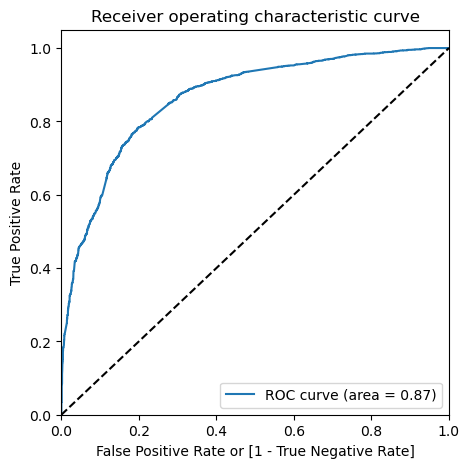

In [532]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

In [533]:

# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,LeadID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.212027,148,0,1,1,1,0,0,0,0,0,0,0
1,1,0.657080,7712,1,1,1,1,1,1,1,1,0,0,0
2,1,0.665153,2784,1,1,1,1,1,1,1,1,0,0,0
3,1,0.993407,5787,1,1,1,1,1,1,1,1,1,1,1
4,1,0.761009,2654,1,1,1,1,1,1,1,1,1,0,0


In [534]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.493765  1.000000  0.000000
0.1   0.1  0.584992  0.984936  0.194901
0.2   0.2  0.685408  0.950377  0.426966
0.3   0.3  0.767009  0.898095  0.639153
0.4   0.4  0.784730  0.849801  0.721262
0.5   0.5  0.787355  0.745680  0.828003
0.6   0.6  0.776854  0.679220  0.872083
0.7   0.7  0.735725  0.557377  0.909680
0.8   0.8  0.709473  0.463890  0.949006
0.9   0.9  0.640998  0.291094  0.982282


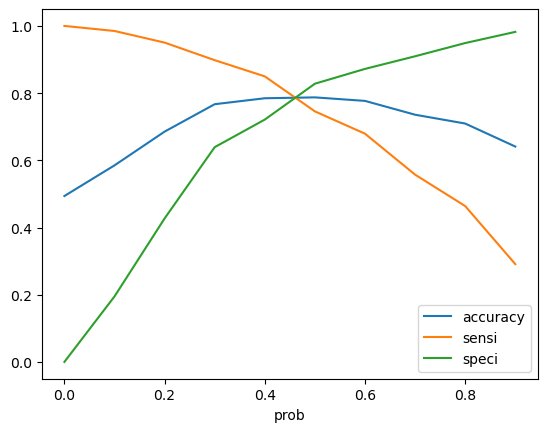

In [535]:
# Let's plot accuracy, sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [536]:
# Find the probability that maximizes accuracy
best_cutoff = cutoff_df.loc[cutoff_df['accuracy'].idxmax(), 'prob']

# Print the best cutoff probability
print(f"Best cutoff probability for maximum accuracy: {best_cutoff}")

Best cutoff probability for maximum accuracy: 0.5


In [537]:
# Find the probability where sensitivity and specificity are closest

cutoff_df['diff'] = abs(cutoff_df['sensi'] - cutoff_df['speci'])
best_cutoff_balanced = cutoff_df.loc[cutoff_df['diff'].idxmin(), 'prob']

print(f"Best cutoff probability for balanced sensitivity & specificity: {best_cutoff_balanced}")

Best cutoff probability for balanced sensitivity & specificity: 0.5


In [538]:
# from the above curve, 0.4 is the optimum point to take the cutoff probability

y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.4 else 0)

y_train_pred_final.head()

,Converted,Converted_Prob,LeadID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.212027,148,0,1,1,1,0,0,0,0,0,0,0,0
1,1,0.657080,7712,1,1,1,1,1,1,1,1,0,0,0,1
2,1,0.665153,2784,1,1,1,1,1,1,1,1,0,0,0,1
3,1,0.993407,5787,1,1,1,1,1,1,1,1,1,1,1,1
4,1,0.761009,2654,1,1,1,1,1,1,1,1,1,0,0,1


In [539]:
# assigning lead score 

y_train_pred_final['lead_score'] = round(y_train_pred_final['Converted_Prob'] * 100, 0)
y_train_pred_final['lead_score'] = y_train_pred_final['lead_score'].astype(int)

y_train_pred_final.head()

,Converted,Converted_Prob,LeadID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,lead_score
0,0,0.212027,148,0,1,1,1,0,0,0,0,0,0,0,0,21
1,1,0.657080,7712,1,1,1,1,1,1,1,1,0,0,0,1,66
2,1,0.665153,2784,1,1,1,1,1,1,1,1,0,0,0,1,67
3,1,0.993407,5787,1,1,1,1,1,1,1,1,1,1,1,1,99
4,1,0.761009,2654,1,1,1,1,1,1,1,1,1,0,0,1,76


In [540]:
##Check over all accuracy

metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.784729818420477

In [541]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[1669,  645],
       [ 339, 1918]])

In [542]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [543]:
# Let's see the sensitivity of our logistic regression model

TP / float(TP+FN)

0.8498006202924235

In [544]:
# Let us calculate specificity

TN / float(TN+FP)

0.7212618841832324

In [545]:
# Calculate false postive rate - predicting churn when customer does not have churned

print(FP/ float(TN+FP))

0.2787381158167675


In [546]:
# Positive predictive value 

print (TP / float(TP+FP))

0.7483417869683964


In [547]:
# Negative predictive value

print (TN / float(TN+ FN))

0.8311752988047809


In [548]:
# precision scrore

precision_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.8087457952907257

In [549]:

recall_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.745680106335844

In [550]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_Prob)

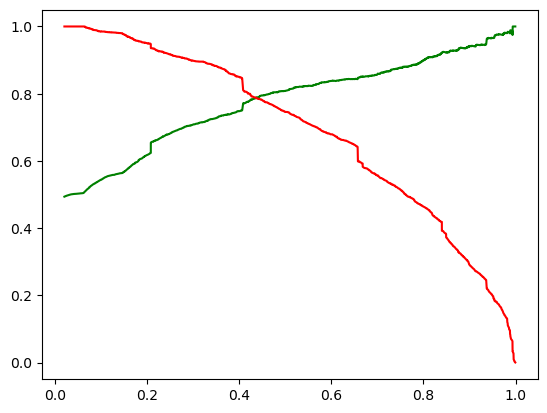

In [551]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [553]:
#scaling the test dataset

X_test[['TotalVisits', 'Total Time Spent on Website']] = scaler.fit_transform(X_test[['TotalVisits','Total Time Spent on Website']])

In [554]:
X_test = X_test[col]
X_test.head()

,Do Not Email,Total Time Spent on Website,Lead Origin_Lead Add Form,Lead Source_Olark Chat,Lead Source_Welingak Website,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Unreachable,Last Activity_SMS Sent,What is your current occupation_Working Professional
2182,0,-0.882730,0,0,0,1,0,0,1,0
2033,0,1.886751,0,0,0,0,0,0,0,0
7383,0,-0.330246,0,1,0,0,0,0,0,0
5494,0,-0.444979,0,0,0,1,0,0,0,0
5410,0,-0.293178,0,0,0,0,0,0,0,0


In [555]:
X_test_sm = sm.add_constant(X_test)

In [556]:
# making predictions on the test datset

y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]

2182    0.164611
2033    0.800597
7383    0.576563
5494    0.102838
5410    0.261535
8235    0.076113
4963    0.871699
8183    0.816187
4335    0.664438
4396    0.073448
dtype: float64

In [557]:
# Converting y_pred to a dataframe which is an array

y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1

,0
2182,0.164611
2033,0.800597
7383,0.576563
5494,0.102838
5410,0.261535
...,...
4611,0.402477
5496,0.182716
4128,0.234778
4676,0.664438


In [558]:
# Converting y_test to dataframe

y_test_df = pd.DataFrame(y_test)
y_test_df

,Converted
2182,1
2033,0
7383,0
5494,0
5410,0
...,...
4611,0
5496,0
4128,0
4676,1


In [559]:
# Putting CustID to index
y_test_df['LeadID'] = y_test_df.index
y_test_df

,Converted,LeadID
2182,1,2182
2033,0,2033
7383,0,7383
5494,0,5494
5410,0,5410
...,...,...
4611,0,4611
5496,0,5496
4128,0,4128
4676,1,4676


In [560]:
# Removing index for both dataframes to append them side by side 

y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [561]:
# Appending y_test_df and y_pred_1 and renaming the column

y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Prob'})
y_pred_final

,Converted,LeadID,Converted_Prob
0,1,2182,0.164611
1,0,2033,0.800597
2,0,7383,0.576563
3,0,5494,0.102838
4,0,5410,0.261535
...,...,...,...
1955,0,4611,0.402477
1956,0,5496,0.182716
1957,0,4128,0.234778
1958,1,4676,0.664438


In [562]:
# Rearranging the columns

y_pred_final = y_pred_final.reindex(columns = ['LeadID','Converted','Converted_Prob'])
y_pred_final.head()

,LeadID,Converted,Converted_Prob
0,2182,1,0.164611
1,2033,0,0.800597
2,7383,0,0.576563
3,5494,0,0.102838
4,5410,0,0.261535


In [563]:
# finding optimal cutoff points
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_pred_final[i]= y_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,LeadID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,lead_score
0,0,0.212027,148,0,1,1,1,0,0,0,0,0,0,0,0,21
1,1,0.657080,7712,1,1,1,1,1,1,1,1,0,0,0,1,66
2,1,0.665153,2784,1,1,1,1,1,1,1,1,0,0,0,1,67
3,1,0.993407,5787,1,1,1,1,1,1,1,1,1,1,1,1,99
4,1,0.761009,2654,1,1,1,1,1,1,1,1,1,0,0,1,76


In [564]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.476531  1.000000  0.000000
0.1   0.1  0.568367  0.985011  0.189084
0.2   0.2  0.680102  0.953961  0.430799
0.3   0.3  0.758673  0.901499  0.628655
0.4   0.4  0.773469  0.845824  0.707602
0.5   0.5  0.794898  0.756959  0.829435
0.6   0.6  0.783163  0.690578  0.867446
0.7   0.7  0.741327  0.553533  0.912281
0.8   0.8  0.718878  0.463597  0.951267
0.9   0.9  0.650510  0.284797  0.983431


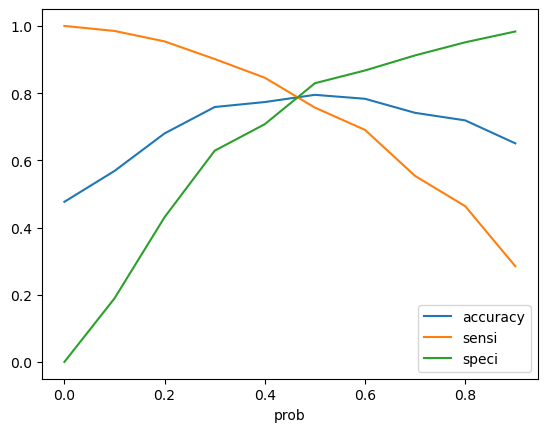

In [565]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [566]:
# Find the probability that maximizes accuracy
best_cutoff =round(cutoff_df.loc[cutoff_df['accuracy'].idxmax(), 'prob'],2)

# Print the best cutoff probability
print(f"Best cutoff probability for maximum accuracy: {best_cutoff}")

Best cutoff probability for maximum accuracy: 0.5


In [567]:
# Find the probability where sensitivity and specificity are closest

cutoff_df['diff'] = abs(cutoff_df['sensi'] - cutoff_df['speci'])
best_cutoff_balanced = cutoff_df.loc[cutoff_df['diff'].idxmin(), 'prob']

print(f"Best cutoff probability for balanced sensitivity & specificity: {best_cutoff_balanced}")

Best cutoff probability for balanced sensitivity & specificity: 0.5


In [568]:
# now applying the cutoff for the final prediction

y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.6 else 0)

In [569]:
# assigning lead score 

y_pred_final['lead_score'] = round(y_pred_final['Converted_Prob'] * 100, 0)
y_pred_final['lead_score'] = y_pred_final['lead_score'].astype(int)

In [570]:
y_pred_final.head()

,LeadID,Converted,Converted_Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,lead_score
0,2182,1,0.164611,1,1,0,0,0,0,0,0,0,0,0,16
1,2033,0,0.800597,1,1,1,1,1,1,1,1,1,0,1,80
2,7383,0,0.576563,1,1,1,1,1,1,0,0,0,0,0,58
3,5494,0,0.102838,1,1,0,0,0,0,0,0,0,0,0,10
4,5410,0,0.261535,1,1,1,0,0,0,0,0,0,0,0,26


In [571]:
# Let's check the overall accuracy

metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.7831632653061225

In [572]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion2

array([[890, 136],
       [289, 645]])

In [573]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [574]:
# precision scrore

precision_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.8258642765685019

In [575]:
# Let's see the sensitivity

TP / float(TP+FN)

0.6905781584582441

In [576]:
# Let us calculate specificity

TN / float(TN+FP)

0.8674463937621832

In [577]:
# precision score

precision_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.8258642765685019

In [578]:
#recall score

recall_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.6905781584582441

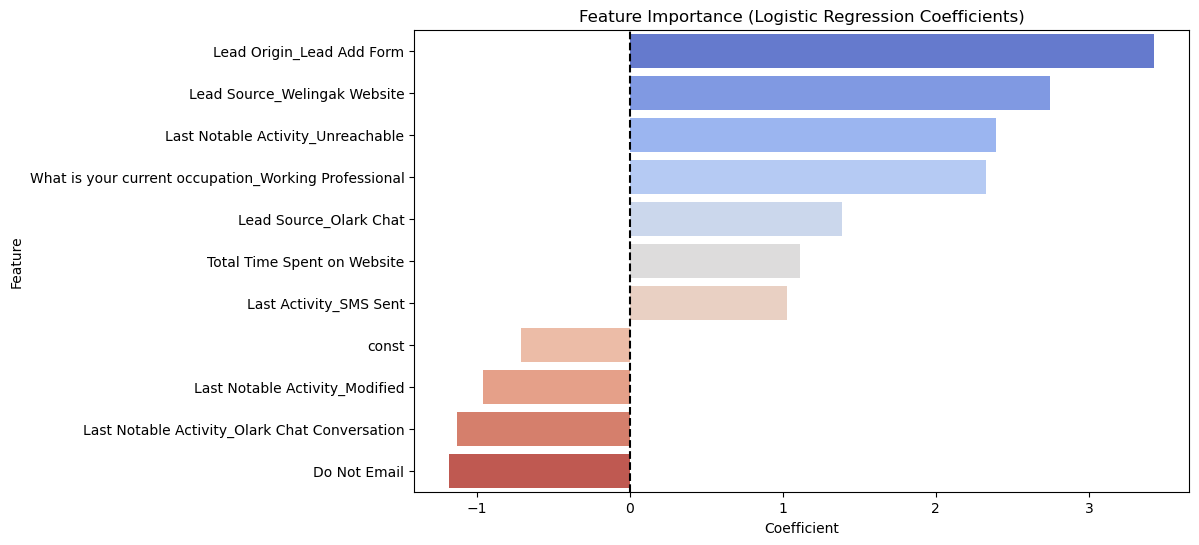

In [579]:
# Extract coefficients
feature_importance = pd.DataFrame({'Feature': X_train_sm.columns, 'Coefficient': res.params})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance, palette='coolwarm')
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

The most important features are those with high values, which also contribute a larger fraction to the evaluation of the model.